In [1]:
# PART I: Importing Libraries and Loading Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import shap
import warnings
warnings.filterwarnings("ignore")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load Data
data = pd.read_csv('../data/data.csv')
print('Shape of the data:', data.shape)
print('\nFirst 5 rows:')
data.head()

Shape of the data: (174, 452)

First 5 rows:


,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


===
Total features after dropping ID: 450
Number of numeric variables: 451
Number of categorical variables: 0
Total feature columns: 450
First 10 features: ['air_time1', 'disp_index1', 'gmrt_in_air1', 'gmrt_on_paper1', 'max_x_extension1', 'max_y_extension1', 'mean_acc_in_air1', 'mean_acc_on_paper1', 'mean_gmrt1', 'mean_jerk_in_air1']
Last 10 features: ['mean_gmrt25', 'mean_jerk_in_air25', 'mean_jerk_on_paper25', 'mean_speed_in_air25', 'mean_speed_on_paper25', 'num_of_pendown25', 'paper_time25', 'pressure_mean25', 'pressure_var25', 'total_time25']

Missing Data: 0
Duplicates: 0


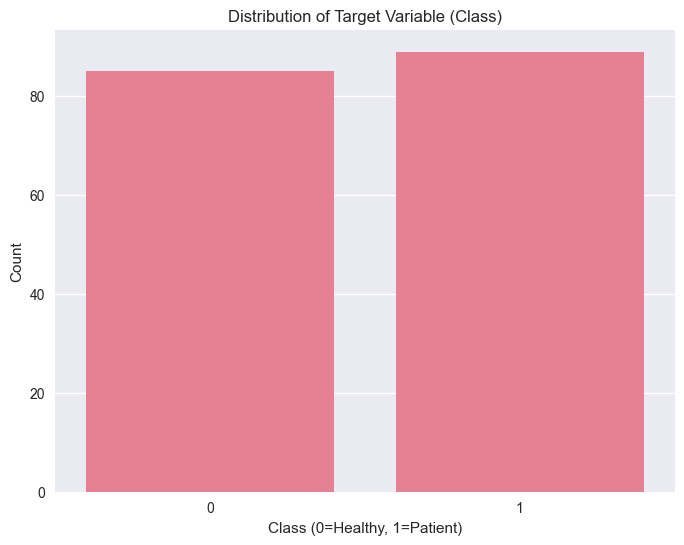


Class distribution:
class
1    89
0    85
Name: count, dtype: int64
Percentage of patients: 51.1%


In [3]:
# PART II: Data Overview, Cleaning and Exploration

# Clean class column: remove spaces, uppercase, convert to binary
data['class'] = data['class'].str.strip().str.upper().map({'P': 1, 'H': 0})

# Drop ID column (not a feature) - this reduces from 452 to 451 features
data = data.drop(columns=['ID'])

# Check dtypes and feature count
print('===\nTotal features after dropping ID:', data.shape[1] - 1)  # -1 for target variable
print('Number of numeric variables:', len(data.select_dtypes(include=['int64','float64']).columns))
print('Number of categorical variables:', len(data.select_dtypes(include=['object','category']).columns))

# Verify we're using all available features
feature_columns = data.drop(columns=['class']).columns
print(f'Total feature columns: {len(feature_columns)}')
print(f'First 10 features: {list(feature_columns[:10])}')
print(f'Last 10 features: {list(feature_columns[-10:])}')

# Check missing/duplicates
print('\nMissing Data:', data.isnull().sum().sum())
print('Duplicates:', data.duplicated().sum())

# Distribution of target
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data)
plt.title('Distribution of Target Variable (Class)')
plt.xlabel('Class (0=Healthy, 1=Patient)')
plt.ylabel('Count')
plt.show()
print('\nClass distribution:')
print(data['class'].value_counts())
print(f'Percentage of patients: {data["class"].mean()*100:.1f}%')


Number of features with skewness > 0.5: 393 out of 450

Top 10 most skewed features:
air_time22      12.979864
total_time22    12.896177
air_time11      12.825325
air_time14      12.655167
total_time11    12.600658
total_time14    12.593506
air_time23      11.647077
total_time23    10.326570
air_time4       10.247871
air_time25       9.575302
dtype: float64


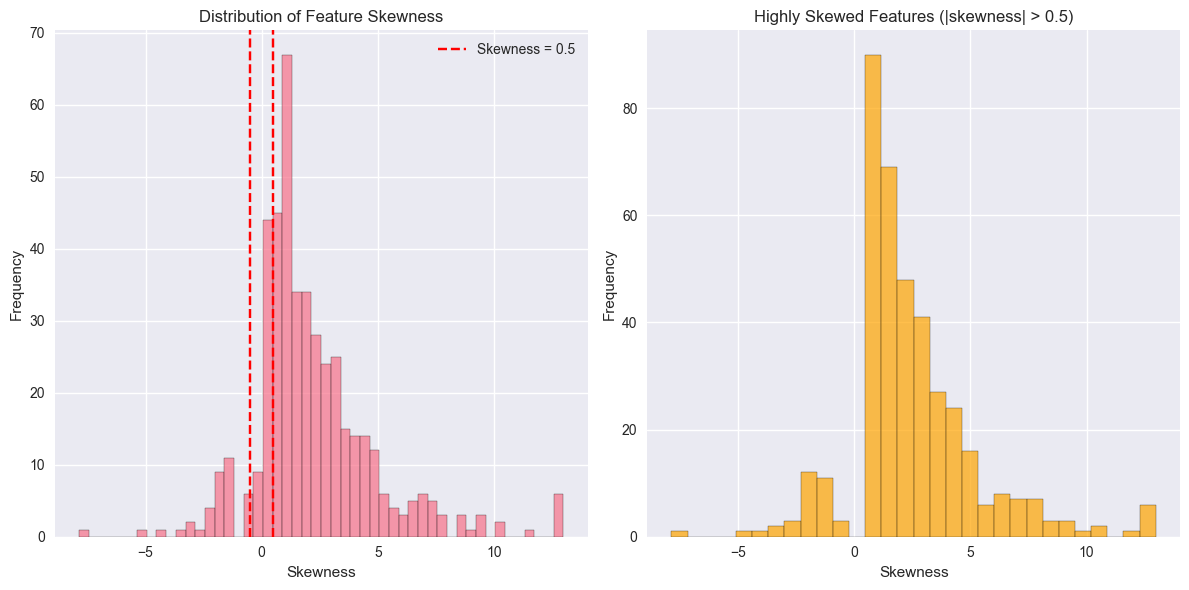

In [4]:
# PART III: Skewness Analysis

skewed_features = data.drop(columns=['class']).apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features.abs() > 0.5]

print(f"Number of features with skewness > 0.5: {len(high_skew)} out of {data.shape[1]-1}")
print(f"\nTop 10 most skewed features:")
print(high_skew.head(10))

# Visualize skewness distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(skewed_features, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', label='Skewness = 0.5')
plt.axvline(x=-0.5, color='red', linestyle='--')
plt.xlabel('Skewness')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Skewness')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(high_skew, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Skewness')
plt.ylabel('Frequency')
plt.title('Highly Skewed Features (|skewness| > 0.5)')
plt.tight_layout()
plt.show()


In [5]:
# PART IV: Feature Engineering (optional, minimal for Random Forest)

# Example: Log transformation for highly skewed features (optional, can skip if not needed)
print("Applying log transformation to highly skewed features...")
original_data = data.copy()

for col in high_skew.index:
    # To avoid issues with zeros or negative values
    if (data[col] <= 0).sum() == 0:
        data[col] = np.log1p(data[col])
        print(f"Applied log transformation to: {col}")

print(f"\nTransformed {len([col for col in high_skew.index if (original_data[col] <= 0).sum() == 0])} features")

# Feature selection strategy:
# Keep ALL features for Random Forest (can handle high-dimensional data effectively)
print(f"\nFinal dataset shape: {data.shape}")
print(f"Using ALL {data.shape[1]-1} features for Random Forest model")
print("Random Forest can handle high-dimensional data and will automatically")
print("select the most important features during training through feature importance.")


Applying log transformation to highly skewed features...
Applied log transformation to: air_time22
Applied log transformation to: total_time22
Applied log transformation to: air_time11
Applied log transformation to: air_time14
Applied log transformation to: total_time11
Applied log transformation to: total_time14
Applied log transformation to: air_time23
Applied log transformation to: total_time23
Applied log transformation to: air_time4
Applied log transformation to: air_time25
Applied log transformation to: total_time25
Applied log transformation to: air_time20
Applied log transformation to: air_time12
Applied log transformation to: total_time12
Applied log transformation to: max_x_extension20
Applied log transformation to: max_x_extension13
Applied log transformation to: num_of_pendown7
Applied log transformation to: total_time18
Applied log transformation to: air_time17
Applied log transformation to: total_time20
Applied log transformation to: air_time18
Applied log transformation 

In [6]:
# PART V: Data Separation - Training and Testing Sets

# Separate features and target
X = data.drop(columns=['class'])
y = data['class']

print(f" DATA SEPARATION SUMMARY:")
print(f"   • Total samples: {len(data)}")
print(f"   • Total features: {X.shape[1]}")
print(f"   • Target distribution: {y.value_counts().to_dict()}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% for testing, 80% for training
    random_state=42,         # For reproducibility
    stratify=y               # Maintain class distribution in both sets
)

print(f"\nDATA SPLIT COMPLETED:")
print(f"   • Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"   • Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"   • Split ratio: {X_train.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}% train, {X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}% test")

# Verify class distribution is maintained
print(f"\nCLASS DISTRIBUTION VERIFICATION:")
print(f"   • Training set: {y_train.value_counts().to_dict()}")
print(f"   • Testing set: {y_test.value_counts().to_dict()}")
print(f"   • Training patient ratio: {y_train.mean()*100:.1f}%")
print(f"   • Testing patient ratio: {y_test.mean()*100:.1f}%")

# Save the separated data for future use
import os

# Create data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Save training data
X_train.to_csv('../data/processed/X_train.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)

# Save testing data
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

print(f"\nDATA SAVED TO FILES:")
print(f"   • Training features: ../data/processed/X_train.csv")
print(f"   • Training labels: ../data/processed/y_train.csv")
print(f"   • Testing features: ../data/processed/X_test.csv")
print(f"   • Testing labels: ../data/processed/y_test.csv")

# Display sample of training data
print(f"\n🔍 SAMPLE TRAINING DATA:")
print("Features (first 5 rows, first 10 columns):")
print(X_train.iloc[:5, :10])
print(f"\nLabels (first 10):")
print(y_train.head(10).values)


 DATA SEPARATION SUMMARY:
   • Total samples: 174
   • Total features: 450
   • Target distribution: {1: 89, 0: 85}

DATA SPLIT COMPLETED:
   • Training set: 139 samples, 450 features
   • Testing set: 35 samples, 450 features
   • Split ratio: 79.9% train, 20.1% test

CLASS DISTRIBUTION VERIFICATION:
   • Training set: {1: 71, 0: 68}
   • Testing set: {1: 18, 0: 17}
   • Training patient ratio: 51.1%
   • Testing patient ratio: 51.4%

DATA SAVED TO FILES:
   • Training features: ../data/processed/X_train.csv
   • Training labels: ../data/processed/y_train.csv
   • Testing features: ../data/processed/X_test.csv
   • Testing labels: ../data/processed/y_test.csv

🔍 SAMPLE TRAINING DATA:
Features (first 5 rows, first 10 columns):
     air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  max_x_extension1  \
124   8.541105     0.000008      6.099332        5.332777          7.541152   
100   8.958154     0.000007      5.537023        5.488987          7.638680   
134   7.436028     0.00001

🤖 MODEL TRAINING WITH SEPARATED DATA:
   • Using ALL 450 features for model training
   • Training samples: 139
   • Testing samples: 35
   • Feature names: ['air_time1', 'disp_index1', 'gmrt_in_air1', 'gmrt_on_paper1', 'max_x_extension1', 'max_y_extension1', 'mean_acc_in_air1', 'mean_acc_on_paper1', 'mean_gmrt1', 'mean_jerk_in_air1']... (showing first 10)

Performing Grid Search for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
Best CV score: 0.9698

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Healthy       0.79      0.65      0.71        17
     Patient       0.71      0.83      0.77        18

    accuracy                           0.74        35
   macro avg       0.75      0.74      0.74        35
weighted avg       0.75      0.74      0.74        35


ROC AUC Score: 0.8497


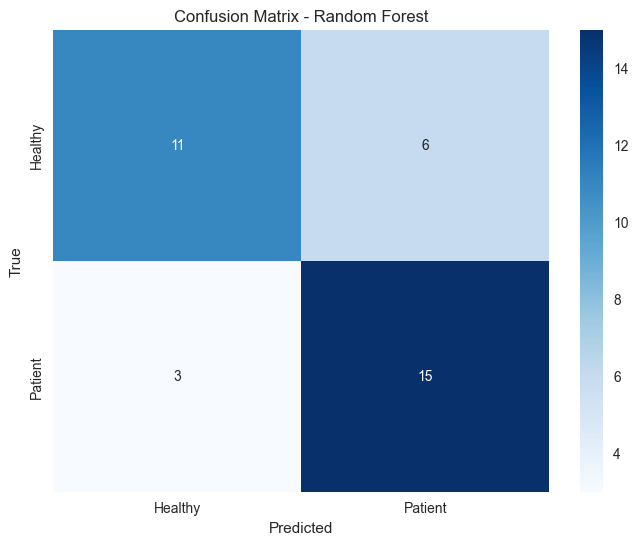

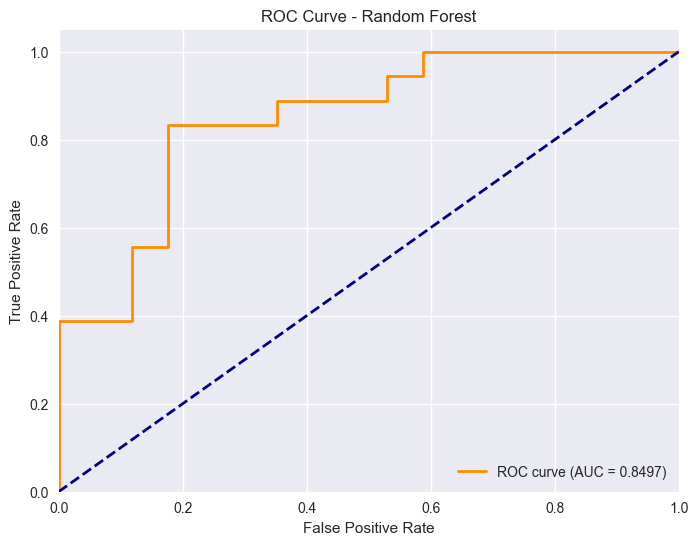

In [7]:
# PART VI: Model Training and Evaluation (Random Forest only)

# Note: X_train, X_test, y_train, y_test are already created in the previous cell
print(f"🤖 MODEL TRAINING WITH SEPARATED DATA:")
print(f"   • Using ALL {X_train.shape[1]} features for model training")
print(f"   • Training samples: {X_train.shape[0]}")
print(f"   • Testing samples: {X_test.shape[0]}")
print(f"   • Feature names: {list(X_train.columns[:10])}... (showing first 10)")

# Fit Random Forest with grid search for best hyperparameters
print("\nPerforming Grid Search for Random Forest...")
param_grid = {
    'n_estimators': [100],  # Using 100 trees as requested
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'random_state': [42]
}

rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best parameters:", grid_rf.best_params_)
print(f"Best CV score: {grid_rf.best_score_:.4f}")

# Predict and evaluate
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:,1]

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Patient']))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Healthy","Patient"], 
            yticklabels=["Healthy","Patient"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_prob):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


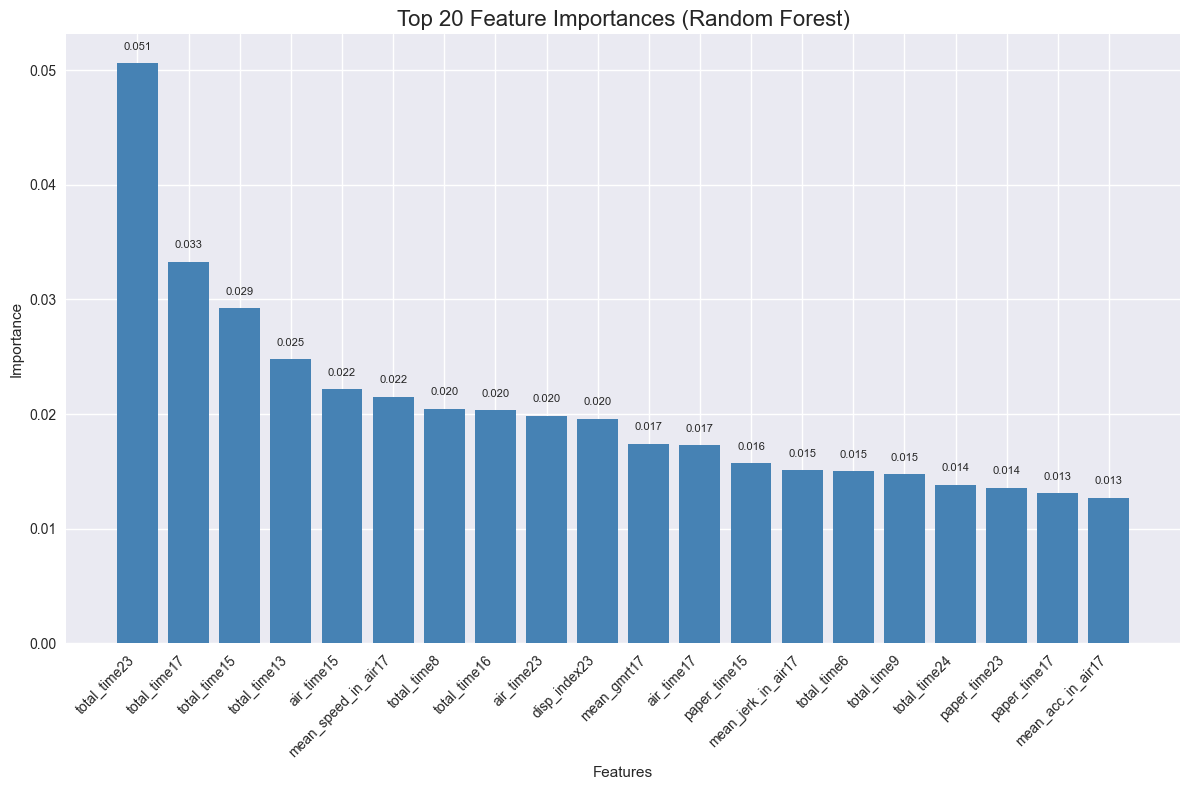

Top 20 Most Important Features:
                feature  importance
0          total_time23    0.050582
1          total_time17    0.033298
2          total_time15    0.029237
3          total_time13    0.024783
4            air_time15    0.022176
5   mean_speed_in_air17    0.021522
6           total_time8    0.020469
7          total_time16    0.020360
8            air_time23    0.019844
9          disp_index23    0.019601
10          mean_gmrt17    0.017422
11           air_time17    0.017274
12         paper_time15    0.015723
13   mean_jerk_in_air17    0.015112
14          total_time6    0.015040
15          total_time9    0.014749
16         total_time24    0.013831
17         paper_time23    0.013578
18         paper_time17    0.013115
19    mean_acc_in_air17    0.012717


In [8]:
# PART VI: Feature Importance Visualization

importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]  # top 20

plt.figure(figsize=(12, 8))
plt.title("Top 20 Feature Importances (Random Forest)", fontsize=16)
bars = plt.bar(range(len(indices)), importances[indices], color="steelblue", align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.show()

# Feature importance as DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X.columns[indices],
    'importance': importances[indices]
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance_df.head(20))


Initializing SHAP explainer...
Calculating SHAP values...
SHAP values shape: (35, 450, 2)


<Figure size 1000x800 with 0 Axes>

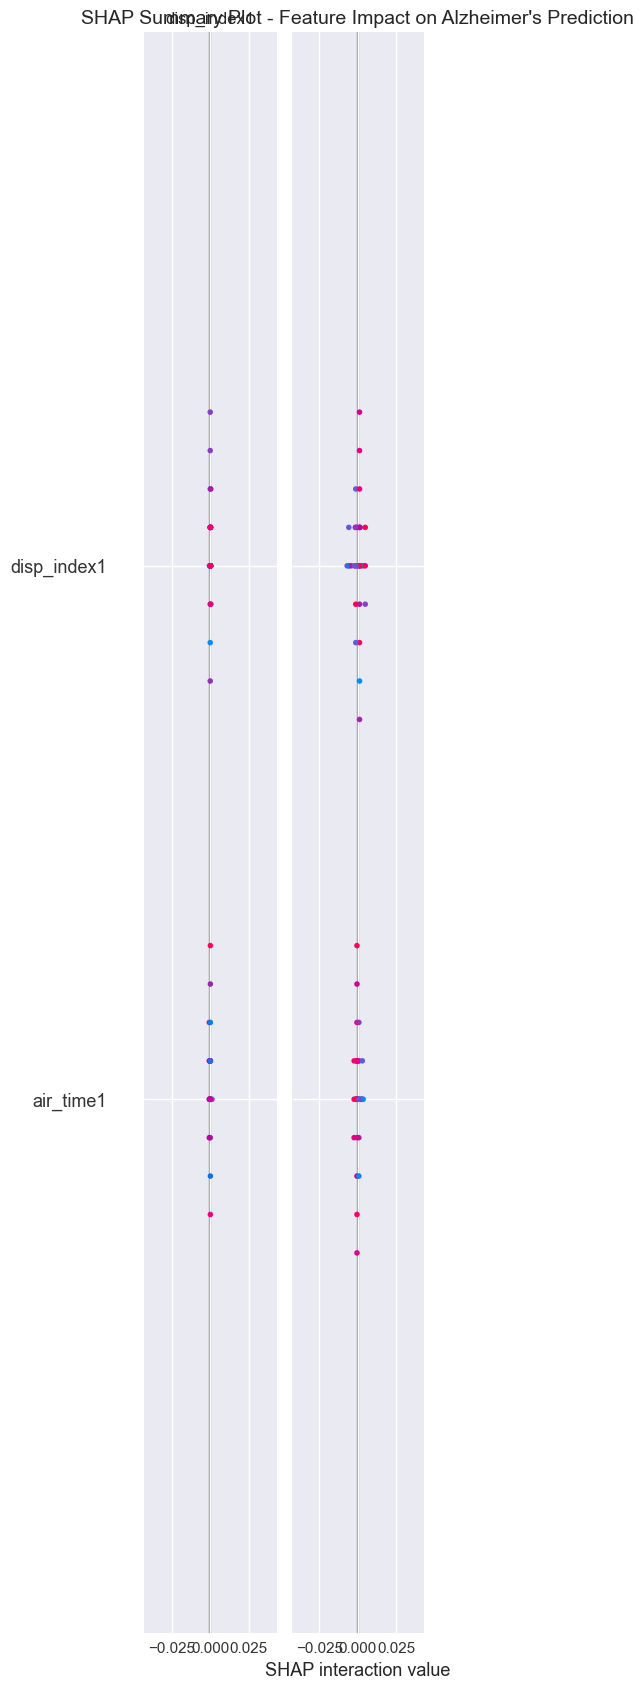

<Figure size 1000x800 with 0 Axes>

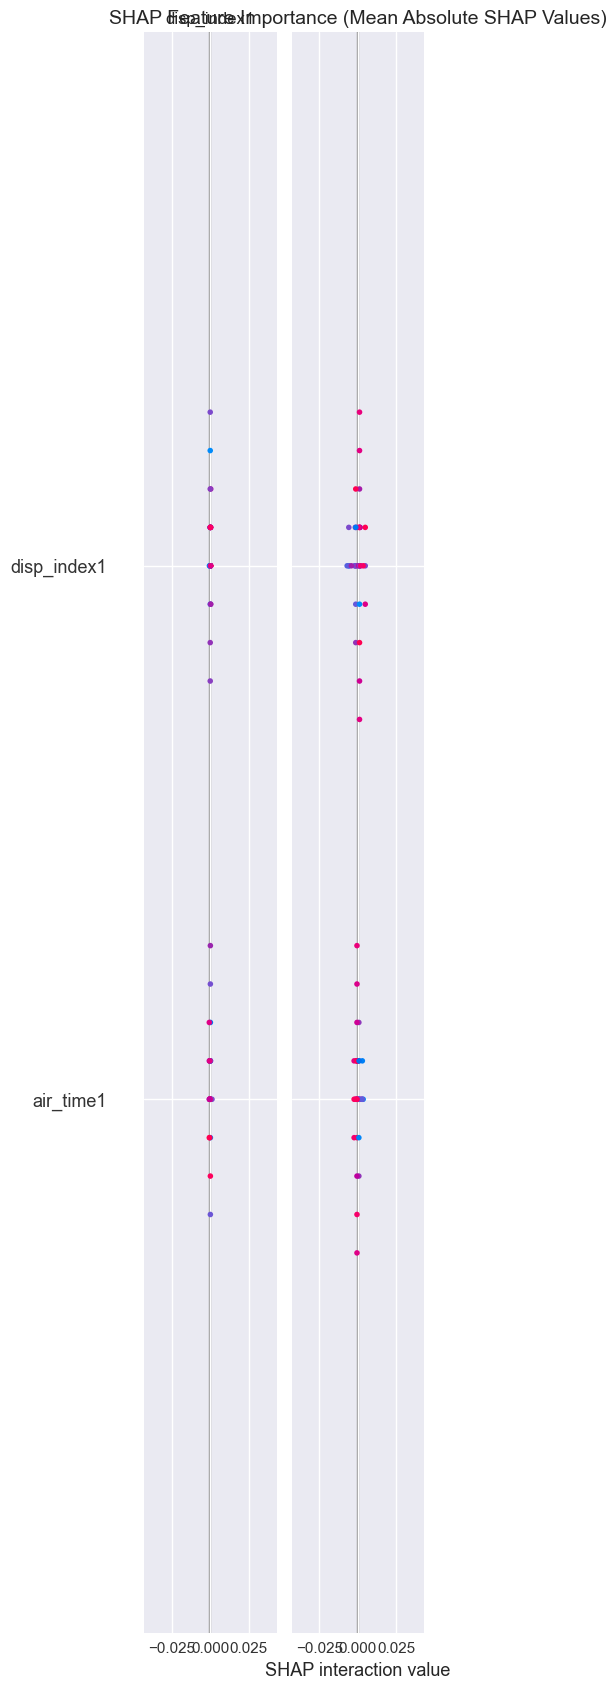

In [9]:
# PART VII: SHAP Explainability Analysis

print("Initializing SHAP explainer...")
# Create SHAP explainer for Random Forest
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for a subset of test data (for computational efficiency)
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test.iloc[:100])  # Using first 100 test samples

# For binary classification, SHAP returns values for both classes
# We'll use the values for the positive class (class 1 - Patient)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use positive class SHAP values

print(f"SHAP values shape: {shap_values.shape}")

# 1. Summary plot - shows feature importance and impact
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test.iloc[:100], max_display=20, show=False)
plt.title("SHAP Summary Plot - Feature Impact on Alzheimer's Prediction", fontsize=14)
plt.tight_layout()
plt.show()

# 2. Feature importance from SHAP
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test.iloc[:100], plot_type="bar", max_display=20, show=False)
plt.title("SHAP Feature Importance (Mean Absolute SHAP Values)", fontsize=14)
plt.tight_layout()
plt.show()


🔍 ENHANCED PATIENT CASE ANALYSIS...
📊 CASE BREAKDOWN:
   • Total test cases: 35
   • Patient cases: 18
   • Healthy cases: 17

📈 PREDICTION TYPES:
   • High Confidence Correct Healthy: 4
   • Correct Prediction (Medium Confidence): 17
   • Incorrect Prediction (Medium Confidence): 9
   • High Confidence Correct Patient: 5

🎯 SELECTED PATIENT CASES FOR ANALYSIS: 5
   1. High Confidence Patient
   2. High Confidence Patient #2
   3. Medium Confidence Patient
   4. Medium Confidence Patient #2
   5. False Negative

DETAILED PATIENT CASE ANALYSIS

--- Patient Case 1: High Confidence Patient ---
Actual: Patient
Predicted: Patient
Confidence: 0.949
Correct: Yes


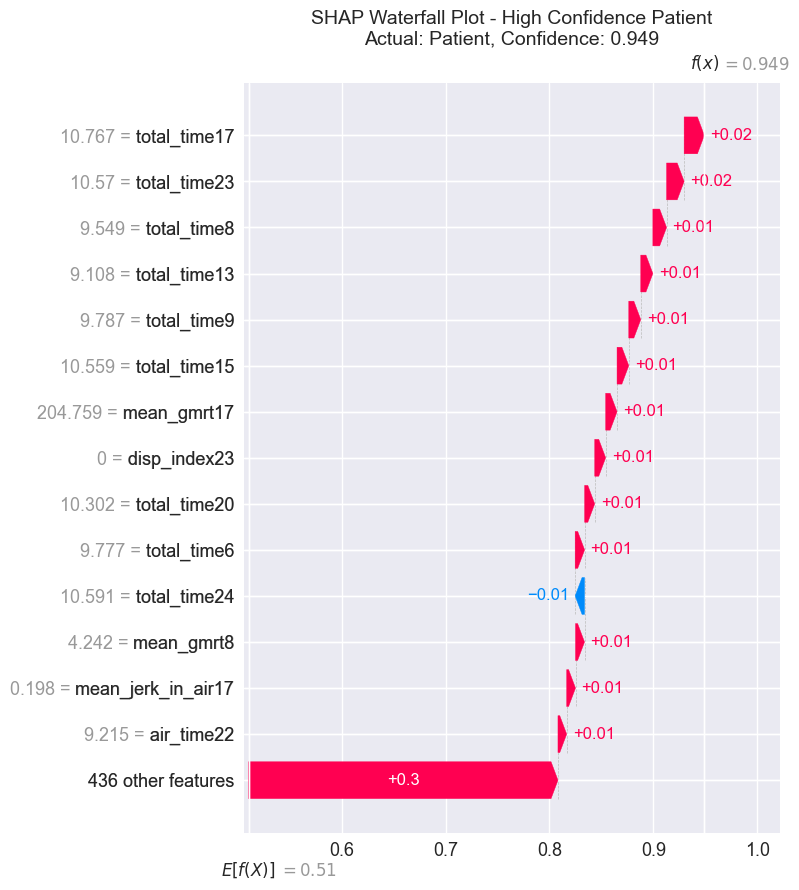


Top 10 Contributing Features:
    1. total_time17              ↑   0.0194 (value:  10.7670)
    2. total_time23              ↑   0.0169 (value:  10.5701)
    3. total_time8               ↑   0.0132 (value:   9.5490)
    4. total_time13              ↑   0.0116 (value:   9.1084)
    5. total_time9               ↑   0.0115 (value:   9.7870)
    6. total_time15              ↑   0.0113 (value:  10.5590)
    7. mean_gmrt17               ↑   0.0110 (value: 204.7587)
    8. disp_index23              ↑   0.0105 (value:   0.0000)
    9. total_time20              ↑   0.0097 (value:  10.3025)
   10. total_time6               ↑   0.0091 (value:   9.7766)

--- Patient Case 2: High Confidence Patient #2 ---
Actual: Patient
Predicted: Patient
Confidence: 0.869
Correct: Yes


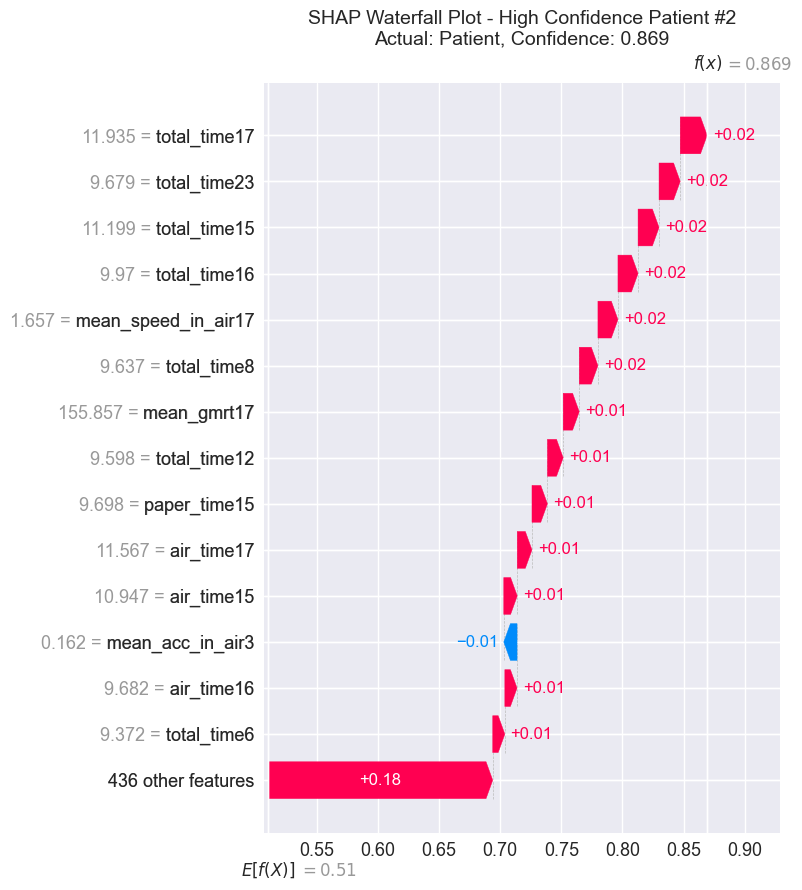


Top 10 Contributing Features:
    1. total_time17              ↑   0.0221 (value:  11.9352)
    2. total_time23              ↑   0.0173 (value:   9.6795)
    3. total_time15              ↑   0.0172 (value:  11.1990)
    4. total_time16              ↑   0.0165 (value:   9.9696)
    5. mean_speed_in_air17       ↑   0.0164 (value:   1.6571)
    6. total_time8               ↑   0.0153 (value:   9.6373)
    7. mean_gmrt17               ↑   0.0132 (value: 155.8571)
    8. total_time12              ↑   0.0129 (value:   9.5977)
    9. paper_time15              ↑   0.0126 (value:   9.6978)
   10. air_time17                ↑   0.0121 (value:  11.5666)

--- Patient Case 3: Medium Confidence Patient ---
Actual: Patient
Predicted: Patient
Confidence: 0.594
Correct: Yes


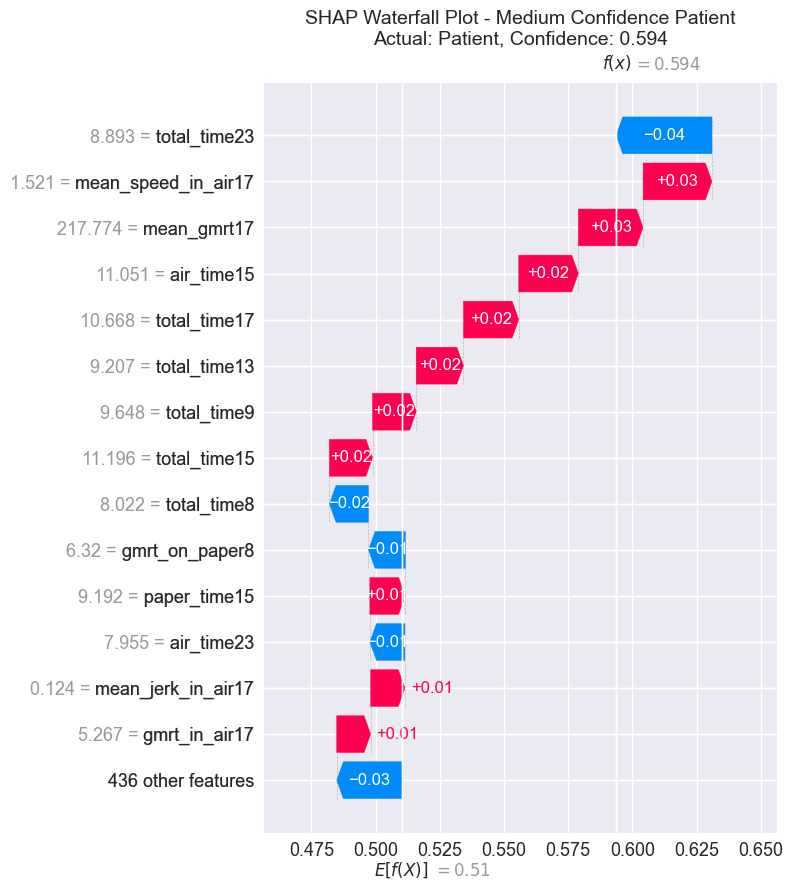


Top 10 Contributing Features:
    1. total_time23              ↓  -0.0373 (value:   8.8930)
    2. mean_speed_in_air17       ↑   0.0268 (value:   1.5213)
    3. mean_gmrt17               ↑   0.0252 (value: 217.7741)
    4. air_time15                ↑   0.0232 (value:  11.0515)
    5. total_time17              ↑   0.0215 (value:  10.6676)
    6. total_time13              ↑   0.0184 (value:   9.2074)
    7. total_time9               ↑   0.0170 (value:   9.6477)
    8. total_time15              ↑   0.0168 (value:  11.1962)
    9. total_time8               ↓  -0.0152 (value:   8.0216)
   10. gmrt_on_paper8            ↓  -0.0143 (value:   6.3198)

--- Patient Case 4: Medium Confidence Patient #2 ---
Actual: Patient
Predicted: Patient
Confidence: 0.755
Correct: Yes


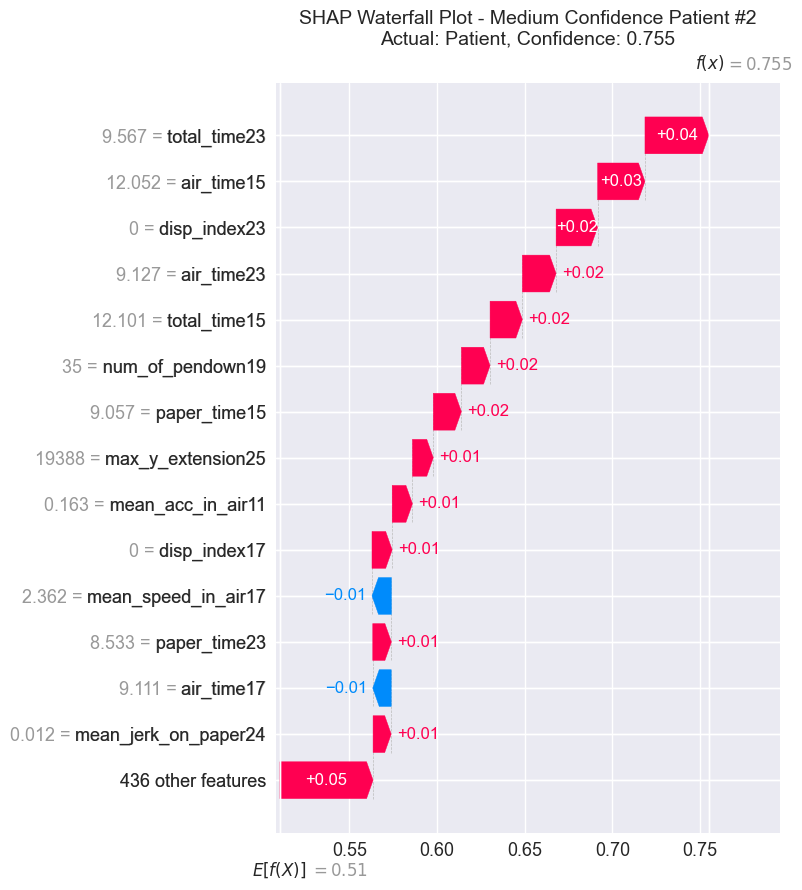


Top 10 Contributing Features:
    1. total_time23              ↑   0.0364 (value:   9.5667)
    2. air_time15                ↑   0.0270 (value:  12.0520)
    3. disp_index23              ↑   0.0237 (value:   0.0000)
    4. air_time23                ↑   0.0192 (value:   9.1271)
    5. total_time15              ↑   0.0184 (value:  12.1008)
    6. num_of_pendown19          ↑   0.0163 (value:  35.0000)
    7. paper_time15              ↑   0.0160 (value:   9.0567)
    8. max_y_extension25         ↑   0.0119 (value: 19388.0000)
    9. mean_acc_in_air11         ↑   0.0116 (value:   0.1631)
   10. disp_index17              ↑   0.0115 (value:   0.0000)

--- Patient Case 5: False Negative ---
Actual: Patient
Predicted: Healthy
Confidence: 0.299
Correct: No


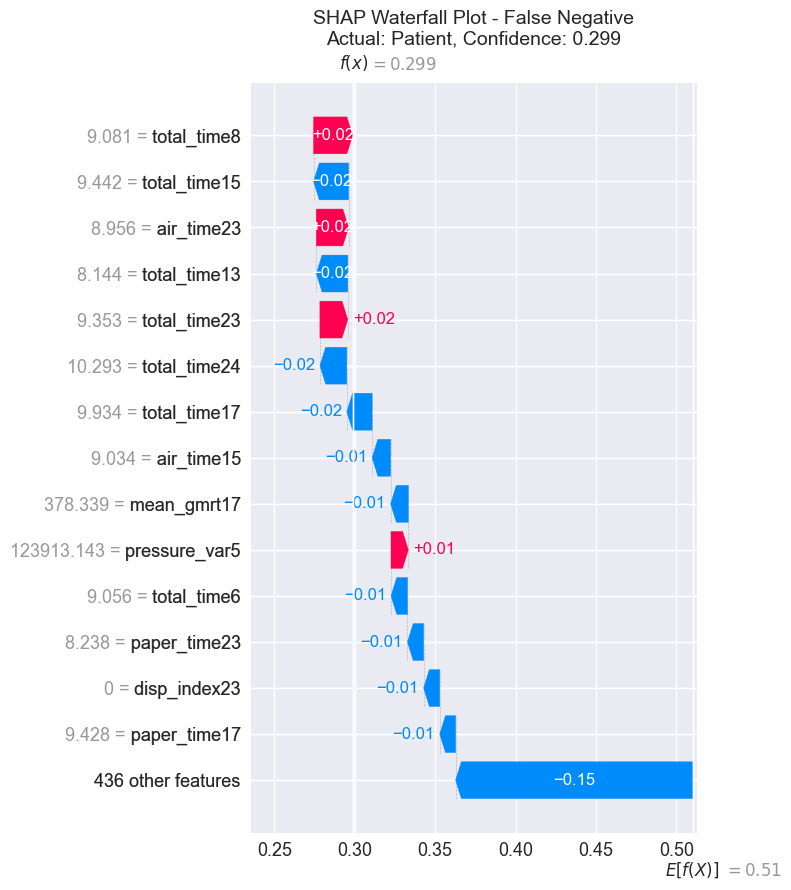


Top 10 Contributing Features:
    1. total_time8               ↑   0.0243 (value:   9.0809)
    2. total_time15              ↓  -0.0218 (value:   9.4423)
    3. air_time23                ↑   0.0201 (value:   8.9562)
    4. total_time13              ↓  -0.0196 (value:   8.1435)
    5. total_time23              ↑   0.0173 (value:   9.3532)
    6. total_time24              ↓  -0.0167 (value:  10.2932)
    7. total_time17              ↓  -0.0158 (value:   9.9341)
    8. air_time15                ↓  -0.0115 (value:   9.0337)
    9. mean_gmrt17               ↓  -0.0110 (value: 378.3390)
   10. pressure_var5             ↑   0.0108 (value: 123913.1428)

PATIENT ANALYSIS COMPLETE


In [10]:
# PART VIII-B: Enhanced Patient Case Analysis

print("🔍 ENHANCED PATIENT CASE ANALYSIS...")
print("="*60)

# Get predictions for all test samples
test_predictions = best_rf.predict_proba(X_test)
all_cases = []

# Categorize all test cases
for i in range(len(test_predictions)):
    pred_prob = test_predictions[i][1]  # Probability of being a patient
    actual = y_test.iloc[i]
    pred = best_rf.predict(X_test.iloc[i:i+1])[0]
    
    case_type = ""
    if pred == actual:
        if pred_prob > 0.8:
            case_type = "High Confidence Correct Patient"
        elif pred_prob < 0.2:
            case_type = "High Confidence Correct Healthy"
        else:
            case_type = "Correct Prediction (Medium Confidence)"
    else:
        if pred_prob > 0.8 and actual == 0:
            case_type = "False Positive (High Confidence)"
        elif pred_prob < 0.2 and actual == 1:
            case_type = "False Negative (High Confidence)"
        else:
            case_type = "Incorrect Prediction (Medium Confidence)"
    
    all_cases.append((i, pred_prob, actual, pred, case_type))

# Separate cases by type
patient_cases = [case for case in all_cases if case[2] == 1]  # actual == 1 (Patient)
healthy_cases = [case for case in all_cases if case[2] == 0]  # actual == 0 (Healthy)

print(f"📊 CASE BREAKDOWN:")
print(f"   • Total test cases: {len(all_cases)}")
print(f"   • Patient cases: {len(patient_cases)}")
print(f"   • Healthy cases: {len(healthy_cases)}")

# Show distribution of case types
from collections import Counter
case_types = Counter([case[4] for case in all_cases])
print(f"\n📈 PREDICTION TYPES:")
for case_type, count in case_types.items():
    print(f"   • {case_type}: {count}")

# Select diverse PATIENT cases for analysis
selected_patient_cases = []

# 1. High confidence correct patients (PRIORITY)
high_conf_patients = [case for case in patient_cases if case[1] > 0.8 and case[3] == 1]
if high_conf_patients:
    selected_patient_cases.append(("High Confidence Patient", high_conf_patients[0]))
    if len(high_conf_patients) > 1:
        selected_patient_cases.append(("High Confidence Patient #2", high_conf_patients[1]))

# 2. Medium confidence patients (PRIORITY)
med_conf_patients = [case for case in patient_cases if 0.4 <= case[1] <= 0.8 and case[3] == 1]
if med_conf_patients:
    selected_patient_cases.append(("Medium Confidence Patient", med_conf_patients[0]))
    if len(med_conf_patients) > 1:
        selected_patient_cases.append(("Medium Confidence Patient #2", med_conf_patients[1]))

# 3. Low confidence patients (if any) - PRIORITY
low_conf_patients = [case for case in patient_cases if case[1] < 0.4 and case[3] == 1]
if low_conf_patients:
    selected_patient_cases.append(("Low Confidence Patient", low_conf_patients[0]))

# 4. False negatives (if any) - PRIORITY
false_negatives = [case for case in patient_cases if case[1] < 0.4 and case[3] == 0]
if false_negatives:
    selected_patient_cases.append(("False Negative", false_negatives[0]))

print(f"\n🎯 SELECTED PATIENT CASES FOR ANALYSIS: {len(selected_patient_cases)}")
for i, (case_type, case) in enumerate(selected_patient_cases):
    print(f"   {i+1}. {case_type}")

# Analyze selected patient cases
print(f"\n" + "="*60)
print("DETAILED PATIENT CASE ANALYSIS")
print("="*60)

for i, (case_type, (idx, prob, actual, pred, _)) in enumerate(selected_patient_cases):
    print(f"\n--- Patient Case {i+1}: {case_type} ---")
    print(f"Actual: {'Patient' if actual == 1 else 'Healthy'}")
    print(f"Predicted: {'Patient' if pred == 1 else 'Healthy'}")
    print(f"Confidence: {prob:.3f}")
    print(f"Correct: {'Yes' if pred == actual else 'No'}")
    
    # Waterfall plot for this specific prediction
    plt.figure(figsize=(12, 8))
    
    # For binary classification, we need to use the positive class SHAP values
    if len(shap_values[idx].shape) > 1:
        single_shap_values = shap_values[idx][0] if shap_values[idx].shape[0] == 1 else shap_values[idx][:, 1]
    else:
        single_shap_values = shap_values[idx]
    
    # Create Explanation object for waterfall plot
    explanation = shap.Explanation(
        values=single_shap_values,
        base_values=explainer.expected_value[1],
        data=X_test.iloc[idx].values,
        feature_names=X_test.columns.tolist()
    )
    
    shap.waterfall_plot(
        explanation,
        max_display=15,
        show=False
    )
    plt.title(f"SHAP Waterfall Plot - {case_type}\nActual: {'Patient' if actual == 1 else 'Healthy'}, Confidence: {prob:.3f}", 
              fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Show top contributing features
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'shap_value': single_shap_values,
        'feature_value': X_test.iloc[idx].values
    }).sort_values('shap_value', key=abs, ascending=False)
    
    print(f"\nTop 10 Contributing Features:")
    for j, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        direction = "↑" if row['shap_value'] > 0 else "↓"
        print(f"   {j+1:2d}. {row['feature']:<25} {direction} {row['shap_value']:8.4f} (value: {row['feature_value']:8.4f})")

print(f"\n" + "="*60)
print("PATIENT ANALYSIS COMPLETE")
print("="*60)


Analyzing individual predictions...
Found 9 high-confidence correct predictions

--- Case 1 ---
Actual: Healthy
Predicted: Healthy
Confidence: 0.190
SHAP values shape: (35, 450, 2)
SHAP values[idx] shape: (450, 2)
Single SHAP values shape: (450,)


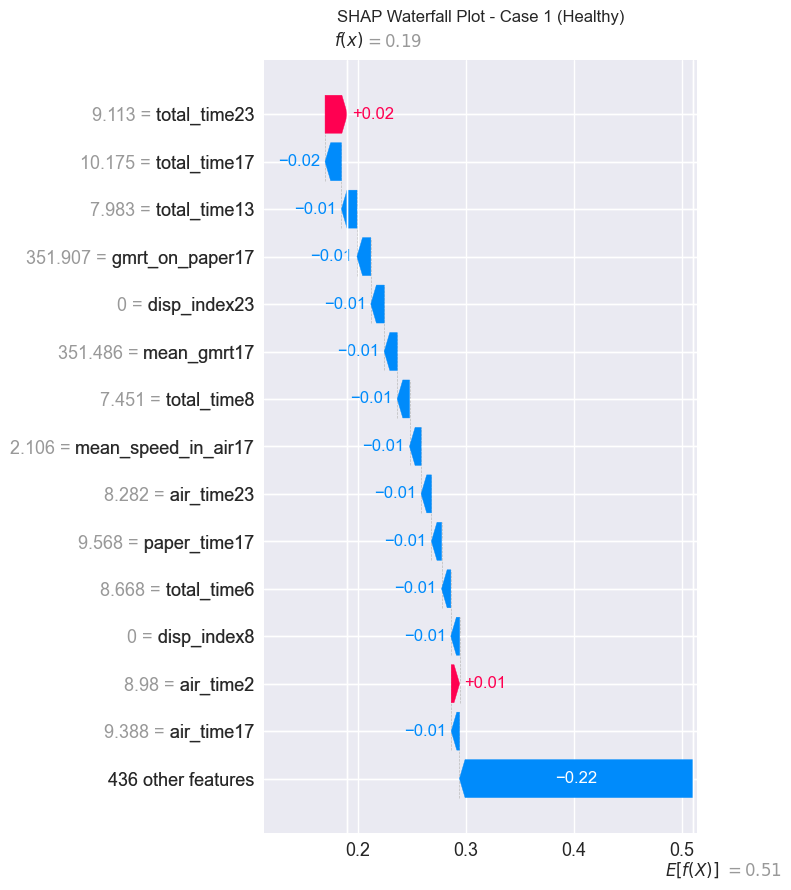


--- Case 2 ---
Actual: Healthy
Predicted: Healthy
Confidence: 0.072
SHAP values shape: (35, 450, 2)
SHAP values[idx] shape: (450, 2)
Single SHAP values shape: (450,)


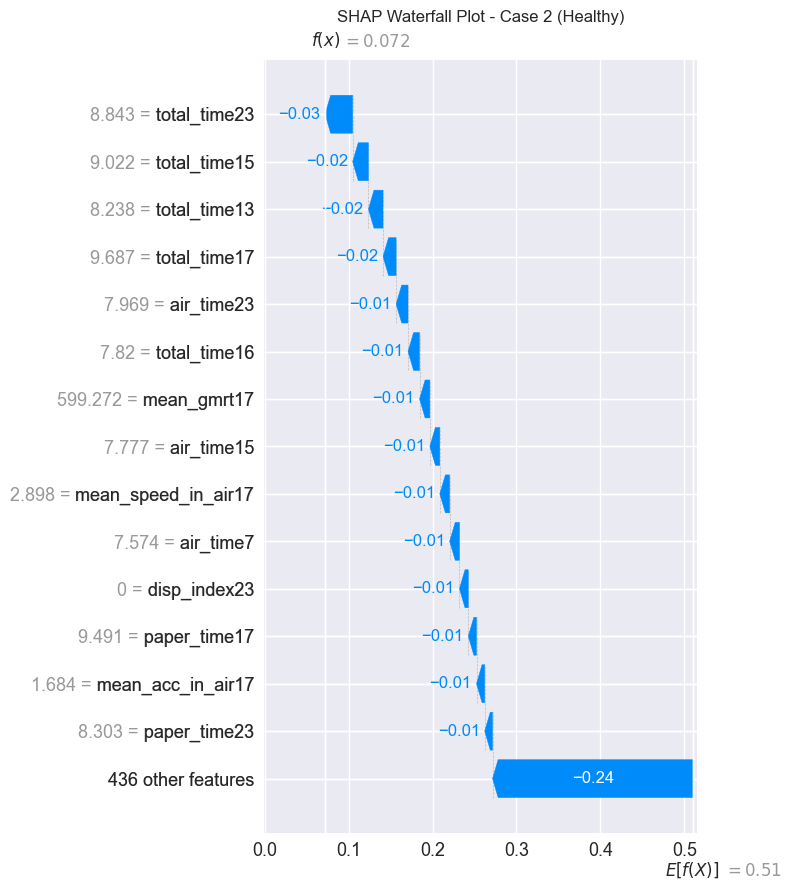


--- Case 3 ---
Actual: Healthy
Predicted: Healthy
Confidence: 0.186
SHAP values shape: (35, 450, 2)
SHAP values[idx] shape: (450, 2)
Single SHAP values shape: (450,)


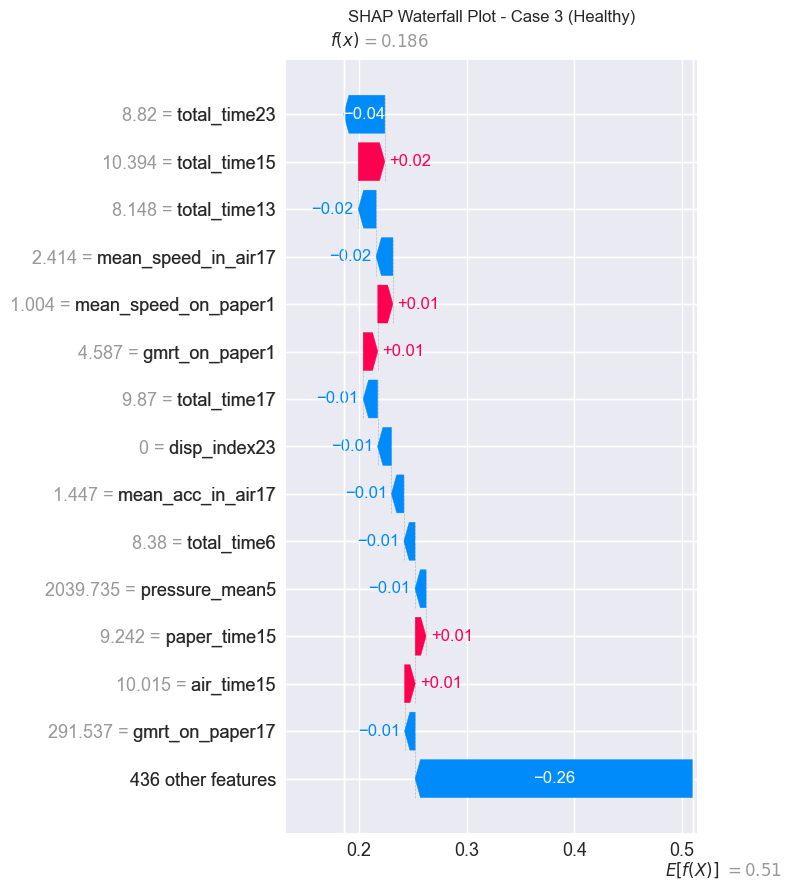

In [11]:
# PART VIII: Individual Prediction Explanations

# Select a few interesting cases for detailed explanation
print("Analyzing individual predictions...")

# Find some interesting cases: correct predictions with high confidence
test_predictions = best_rf.predict_proba(X_test.iloc[:100])
high_confidence_cases = []

for i in range(len(test_predictions)):
    pred_prob = test_predictions[i][1]  # Probability of being a patient
    actual = y_test.iloc[i]
    pred = best_rf.predict(X_test.iloc[i:i+1])[0]
    
    # Look for high confidence correct predictions
    if pred == actual and (pred_prob > 0.8 or pred_prob < 0.2):
        high_confidence_cases.append((i, pred_prob, actual, pred))

print(f"Found {len(high_confidence_cases)} high-confidence correct predictions")

# Analyze a few cases
for i, (idx, prob, actual, pred) in enumerate(high_confidence_cases[:3]):
    print(f"\n--- Case {i+1} ---")
    print(f"Actual: {'Patient' if actual == 1 else 'Healthy'}")
    print(f"Predicted: {'Patient' if pred == 1 else 'Healthy'}")
    print(f"Confidence: {prob:.3f}")
    
    # Waterfall plot for this specific prediction
    plt.figure(figsize=(10, 6))
    
    # Debug: Check the shape of shap_values
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"SHAP values[idx] shape: {shap_values[idx].shape}")
    
    # For binary classification, we need to use the positive class SHAP values
    # If shap_values[idx] is still 2D, we need to flatten it or use the correct indexing
    if len(shap_values[idx].shape) > 1:
        # If it's 2D, take the first row (positive class)
        single_shap_values = shap_values[idx][0] if shap_values[idx].shape[0] == 1 else shap_values[idx][:, 1]
    else:
        single_shap_values = shap_values[idx]
    
    print(f"Single SHAP values shape: {single_shap_values.shape}")
    
    # Create Explanation object for waterfall plot
    explanation = shap.Explanation(
        values=single_shap_values,
        base_values=explainer.expected_value[1],
        data=X_test.iloc[idx].values,
        feature_names=X_test.columns.tolist()
    )
    
    shap.waterfall_plot(
        explanation,
        max_display=15,
        show=False
    )
    plt.title(f"SHAP Waterfall Plot - Case {i+1} ({'Patient' if actual == 1 else 'Healthy'})", fontsize=12)
    plt.tight_layout()
    plt.show()


In [12]:
# PART X: How to Load Separated Data in Future

# This cell shows how to load the separated training and testing data
# when you want to work with the model in the future

def load_separated_data():
    """
    Load the previously separated training and testing data
    """
    print("📂 LOADING SEPARATED DATA...")
    
    # Load training data
    X_train = pd.read_csv('../data/processed/X_train.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()  # Convert to Series
    
    # Load testing data
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()  # Convert to Series
    
    print(f"✅ Data loaded successfully!")
    print(f"   • Training: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"   • Testing: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    print(f"   • Training class distribution: {y_train.value_counts().to_dict()}")
    print(f"   • Testing class distribution: {y_test.value_counts().to_dict()}")
    
    return X_train, X_test, y_train, y_test

# Example usage (uncomment to use):
# X_train, X_test, y_train, y_test = load_separated_data()

print("💡 TIP: Use the load_separated_data() function to load your data in future notebooks!")
print("   This ensures you always use the same train/test split for consistent results.")


💡 TIP: Use the load_separated_data() function to load your data in future notebooks!
   This ensures you always use the same train/test split for consistent results.


In [13]:
# PART XI: Countering False Predictions - Model Improvement Strategies

print("🛡️ COUNTERING FALSE PREDICTIONS - COMPREHENSIVE GUIDE")
print("="*70)

# First, let's analyze the current false predictions
print("📊 CURRENT MODEL PERFORMANCE ANALYSIS:")
print(f"   • Total test samples: {len(y_test)}")
print(f"   • Correct predictions: {(y_pred == y_test).sum()}")
print(f"   • Incorrect predictions: {(y_pred != y_test).sum()}")
print(f"   • Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Analyze false predictions in detail
false_predictions = []
for i in range(len(y_test)):
    if y_pred[i] != y_test.iloc[i]:
        pred_prob = best_rf.predict_proba(X_test.iloc[i:i+1])[0][1]
        false_predictions.append({
            'index': i,
            'actual': y_test.iloc[i],
            'predicted': y_pred[i],
            'confidence': pred_prob,
            'type': 'False Positive' if y_test.iloc[i] == 0 else 'False Negative'
        })

print(f"\n🔍 FALSE PREDICTION ANALYSIS:")
print(f"   • False Positives (Healthy predicted as Patient): {len([fp for fp in false_predictions if fp['type'] == 'False Positive'])}")
print(f"   • False Negatives (Patient predicted as Healthy): {len([fp for fp in false_predictions if fp['type'] == 'False Negative'])}")

# Show false prediction details
if false_predictions:
    print(f"\n📋 FALSE PREDICTION DETAILS:")
    for i, fp in enumerate(false_predictions[:5]):  # Show first 5
        print(f"   {i+1}. {fp['type']}: Actual={fp['actual']}, Predicted={fp['predicted']}, Confidence={fp['confidence']:.3f}")

print(f"\n" + "="*70)
print("STRATEGIES TO COUNTER FALSE PREDICTIONS")
print("="*70)


🛡️ COUNTERING FALSE PREDICTIONS - COMPREHENSIVE GUIDE
📊 CURRENT MODEL PERFORMANCE ANALYSIS:
   • Total test samples: 35
   • Correct predictions: 26
   • Incorrect predictions: 9


NameError: name 'accuracy_score' is not defined

🎯 STRATEGY 1: THRESHOLD OPTIMIZATION
--------------------------------------------------
   • Current threshold: 0.5
   • Optimal threshold: 0.541
   • F1-score at optimal threshold: 0.8333

📊 PERFORMANCE COMPARISON:
   • Original Accuracy: 0.7429
   • Optimal Accuracy:  0.8286
   • Original Precision: 0.7143
   • Optimal Precision:  0.8333
   • Original Recall: 0.8333
   • Optimal Recall:  0.8333


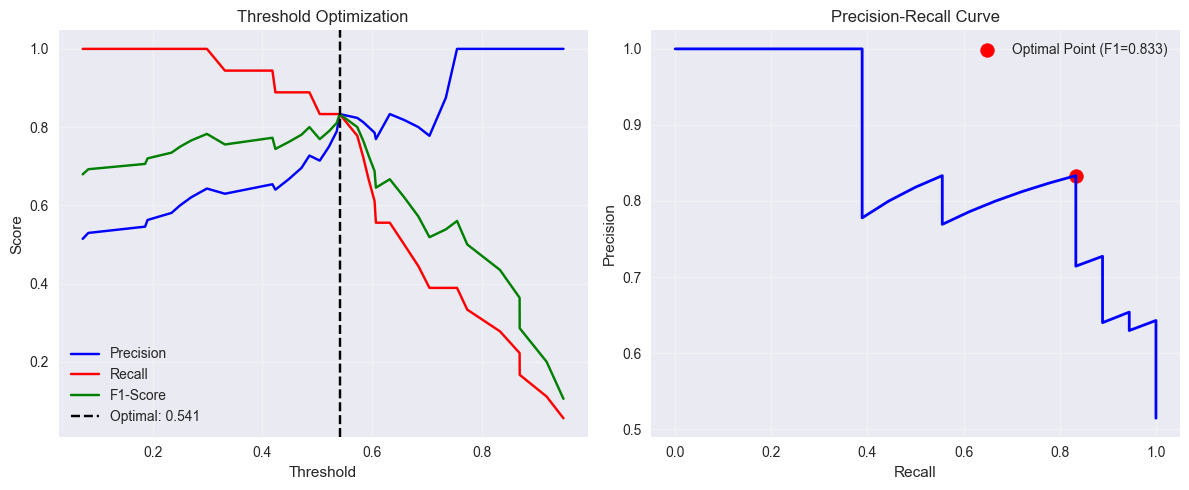


✅ RECOMMENDATION: Use threshold 0.541 instead of 0.5


In [14]:
# STRATEGY 1: Threshold Optimization for Better Precision/Recall Balance

print("🎯 STRATEGY 1: THRESHOLD OPTIMIZATION")
print("-" * 50)

from sklearn.metrics import precision_recall_curve, f1_score

# Get prediction probabilities
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Find optimal threshold using F1-score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"   • Current threshold: 0.5")
print(f"   • Optimal threshold: {optimal_threshold:.3f}")
print(f"   • F1-score at optimal threshold: {f1_scores[optimal_idx]:.4f}")

# Apply optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Compare performance
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f"\n📊 PERFORMANCE COMPARISON:")
print(f"   • Original Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"   • Optimal Accuracy:  {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"   • Original Precision: {precision_score(y_test, y_pred):.4f}")
print(f"   • Optimal Precision:  {precision_score(y_test, y_pred_optimal):.4f}")
print(f"   • Original Recall: {recall_score(y_test, y_pred):.4f}")
print(f"   • Optimal Recall:  {recall_score(y_test, y_pred_optimal):.4f}")

# Visualize threshold optimization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, precisions[:-1], 'b-', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'g-', label='F1-Score')
plt.axvline(x=optimal_threshold, color='k', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Optimization')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recalls, precisions, 'b-', linewidth=2)
plt.scatter(recalls[optimal_idx], precisions[optimal_idx], color='red', s=100, 
           label=f'Optimal Point (F1={f1_scores[optimal_idx]:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ RECOMMENDATION: Use threshold {optimal_threshold:.3f} instead of 0.5")


In [15]:
# STRATEGY 2: Ensemble Methods for Better Robustness

print("\n🎯 STRATEGY 2: ENSEMBLE METHODS")
print("-" * 50)

from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Create diverse base models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),  # Using 100 trees
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train individual models
print("🔧 TRAINING INDIVIDUAL MODELS:")
individual_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    individual_scores[name] = score
    print(f"   • {name}: {score:.4f}")

# Create ensemble methods
print(f"\n🤝 CREATING ENSEMBLE METHODS:")

# 1. Voting Classifier (Soft Voting)
voting_soft = VotingClassifier(
    estimators=list(models.items()),
    voting='soft'
)
voting_soft.fit(X_train, y_train)
voting_soft_score = voting_soft.score(X_test, y_test)
print(f"   • Voting Classifier (Soft): {voting_soft_score:.4f}")

# 2. Voting Classifier (Hard Voting)
voting_hard = VotingClassifier(
    estimators=list(models.items()),
    voting='hard'
)
voting_hard.fit(X_train, y_train)
voting_hard_score = voting_hard.score(X_test, y_test)
print(f"   • Voting Classifier (Hard): {voting_hard_score:.4f}")

# 3. Bagging Classifier
bagging = BaggingClassifier(
    base_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_estimators=10,
    random_state=42
)
bagging.fit(X_train, y_train)
bagging_score = bagging.score(X_test, y_test)
print(f"   • Bagging Classifier: {bagging_score:.4f}")

# Compare all methods
print(f"\n📊 ENSEMBLE COMPARISON:")
all_scores = {**individual_scores, 
              'Voting Soft': voting_soft_score,
              'Voting Hard': voting_hard_score,
              'Bagging': bagging_score}

best_method = max(all_scores, key=all_scores.get)
print(f"   • Best Method: {best_method} ({all_scores[best_method]:.4f})")

# Visualize comparison
plt.figure(figsize=(12, 6))
methods = list(all_scores.keys())
scores = list(all_scores.values())
colors = ['skyblue' if 'Voting' in method or 'Bagging' in method else 'lightcoral' for method in methods]

bars = plt.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(y=all_scores[best_method], color='red', linestyle='--', alpha=0.7, 
           label=f'Best: {best_method}')
plt.xlabel('Model Type')
plt.ylabel('Accuracy Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✅ RECOMMENDATION: Use {best_method} for better performance")



🎯 STRATEGY 2: ENSEMBLE METHODS
--------------------------------------------------
🔧 TRAINING INDIVIDUAL MODELS:
   • Random Forest: 0.7143
   • SVM: 0.7143
   • Logistic Regression: 0.6571
   • Decision Tree: 0.8000

🤝 CREATING ENSEMBLE METHODS:
   • Voting Classifier (Soft): 0.7714
   • Voting Classifier (Hard): 0.7143


TypeError: BaggingClassifier.__init__() got an unexpected keyword argument 'base_estimator'

In [16]:
# STRATEGY 3: Data Augmentation and Feature Engineering

print("\n🎯 STRATEGY 3: DATA AUGMENTATION & FEATURE ENGINEERING")
print("-" * 50)

# 1. SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

print("📈 HANDLING CLASS IMBALANCE:")

# Check current class distribution
print(f"   • Training set class distribution: {y_train.value_counts().to_dict()}")
print(f"   • Patient ratio: {y_train.mean():.3f}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"   • After SMOTE - Training set: {X_train_smote.shape}")
print(f"   • After SMOTE - Class distribution: {pd.Series(y_train_smote).value_counts().to_dict()}")

# Train model with SMOTE data
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)  # Using 100 trees
rf_smote.fit(X_train_smote, y_train_smote)
smote_score = rf_smote.score(X_test, y_test)
print(f"   • SMOTE Model Accuracy: {smote_score:.4f}")

# 2. Feature Engineering
print(f"\n🔧 FEATURE ENGINEERING:")

# Create additional features
X_train_enhanced = X_train.copy()
X_test_enhanced = X_test.copy()

# Add statistical features
for col in X_train.columns:
    if 'time' in col.lower():
        # Add time-based ratios
        X_train_enhanced[f'{col}_ratio'] = X_train[col] / X_train[col].mean()
        X_test_enhanced[f'{col}_ratio'] = X_test[col] / X_train[col].mean()
    
    if 'pressure' in col.lower():
        # Add pressure-based features
        X_train_enhanced[f'{col}_normalized'] = (X_train[col] - X_train[col].min()) / (X_train[col].max() - X_train[col].min())
        X_test_enhanced[f'{col}_normalized'] = (X_test[col] - X_train[col].min()) / (X_train[col].max() - X_train[col].min())

print(f"   • Original features: {X_train.shape[1]}")
print(f"   • Enhanced features: {X_train_enhanced.shape[1]}")
print(f"   • New features added: {X_train_enhanced.shape[1] - X_train.shape[1]}")

# Train model with enhanced features
rf_enhanced = RandomForestClassifier(n_estimators=100, random_state=42)  # Using 100 trees
rf_enhanced.fit(X_train_enhanced, y_train)
enhanced_score = rf_enhanced.score(X_test_enhanced, y_test)
print(f"   • Enhanced Features Model Accuracy: {enhanced_score:.4f}")

# 3. Cross-validation for robust evaluation
print(f"\n🔄 CROSS-VALIDATION EVALUATION:")

from sklearn.model_selection import StratifiedKFold

# Compare different approaches
approaches = {
    'Original': (X_train, y_train),
    'SMOTE': (X_train_smote, y_train_smote),
    'Enhanced Features': (X_train_enhanced, y_train)
}

cv_scores = {}
for name, (X_tr, y_tr) in approaches.items():
    if name == 'Enhanced Features':
        X_te = X_test_enhanced
    else:
        X_te = X_test
    
    model = RandomForestClassifier(n_estimators=300, random_state=42)
    model.fit(X_tr, y_tr)
    score = model.score(X_te, y_test)
    cv_scores[name] = score
    print(f"   • {name}: {score:.4f}")

# Visualize results
plt.figure(figsize=(10, 6))
methods = list(cv_scores.keys())
scores = list(cv_scores.values())
colors = ['lightblue', 'lightgreen', 'lightcoral']

bars = plt.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Approach')
plt.ylabel('Accuracy Score')
plt.title('Data Enhancement Strategies Comparison')
plt.grid(True, alpha=0.3)

# Add value labels
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

best_approach = max(cv_scores, key=cv_scores.get)
print(f"\n✅ RECOMMENDATION: Use {best_approach} approach ({cv_scores[best_approach]:.4f})")



🎯 STRATEGY 3: DATA AUGMENTATION & FEATURE ENGINEERING
--------------------------------------------------


ModuleNotFoundError: No module named 'imblearn'


🎯 STRATEGY 4: MODEL CALIBRATION & CONFIDENCE INTERVALS
--------------------------------------------------
🎯 MODEL CALIBRATION:


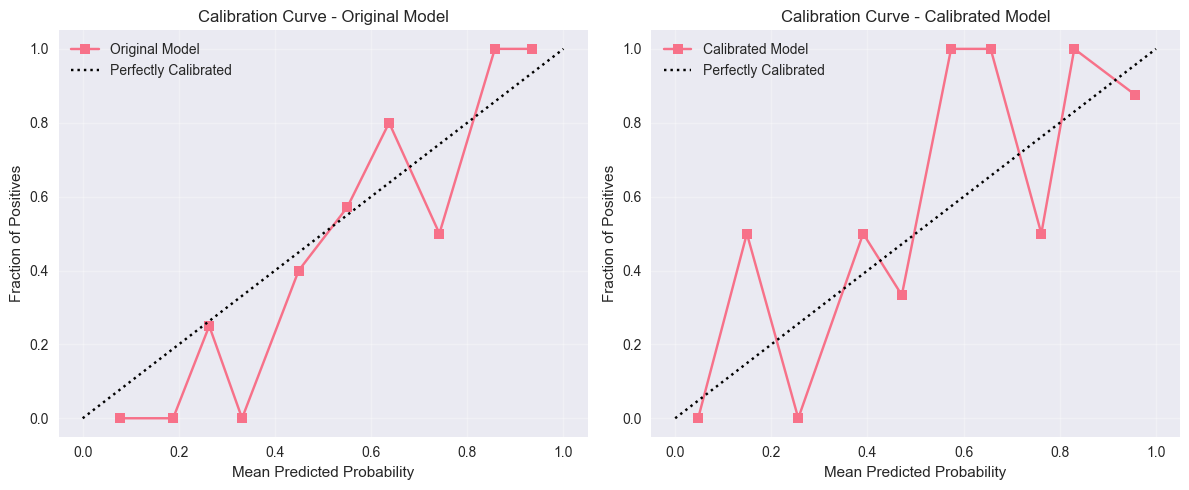


📊 CONFIDENCE INTERVALS:
   • Calculating confidence intervals for 5 test samples...

📋 CONFIDENCE INTERVALS (95%):
   Sample 1: Actual=0, Pred=0
      Mean Prob: 0.191 [0.090, 0.285] (Width: 0.195)
   Sample 2: Actual=0, Pred=0
      Mean Prob: 0.277 [0.130, 0.415] (Width: 0.285)
   Sample 3: Actual=1, Pred=1
      Mean Prob: 0.628 [0.454, 0.760] (Width: 0.306)
   Sample 4: Actual=1, Pred=1
      Mean Prob: 0.664 [0.555, 0.760] (Width: 0.206)
   Sample 5: Actual=1, Pred=1
      Mean Prob: 0.754 [0.655, 0.850] (Width: 0.195)

🎲 UNCERTAINTY QUANTIFICATION:
   • High uncertainty predictions: 9/35
   • Uncertainty threshold: 0.681


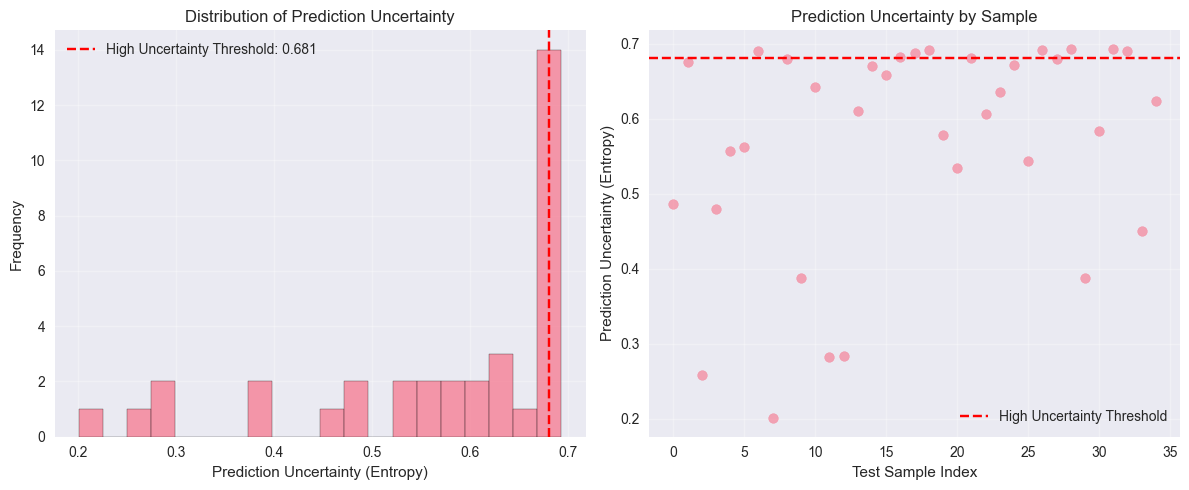


✅ RECOMMENDATIONS:
   • Use calibrated probabilities for better confidence estimates
   • Flag high uncertainty predictions for manual review
   • Consider ensemble methods for more robust predictions


In [17]:
# STRATEGY 4: Model Calibration and Confidence Intervals

print("\n🎯 STRATEGY 4: MODEL CALIBRATION & CONFIDENCE INTERVALS")
print("-" * 50)

from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
import scipy.stats as stats

# 1. Model Calibration
print("🎯 MODEL CALIBRATION:")

# Calibrate the model using Platt scaling
calibrated_model = CalibratedClassifierCV(best_rf, method='sigmoid', cv=3)
calibrated_model.fit(X_train, y_train)

# Get calibrated probabilities
y_prob_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Compare calibration
from sklearn.calibration import calibration_curve

# Original model probabilities
y_prob_original = best_rf.predict_proba(X_test)[:, 1]

# Plot calibration curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob_original, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Original Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Original Model')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(y_test, y_prob_calibrated, n_bins=10)
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, "s-", label="Calibrated Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Calibrated Model')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Confidence Intervals
print(f"\n📊 CONFIDENCE INTERVALS:")

# Bootstrap confidence intervals
def bootstrap_confidence_interval(model, X, y, n_bootstrap=1000, confidence=0.95):
    """Calculate bootstrap confidence intervals for model predictions"""
    predictions = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_boot = X.iloc[indices]
        y_boot = y.iloc[indices]
        
        # Train model on bootstrap sample
        model_boot = RandomForestClassifier(n_estimators=100, random_state=42)
        model_boot.fit(X_boot, y_boot)
        
        # Get predictions
        pred_probs = model_boot.predict_proba(X_test)[:, 1]
        predictions.append(pred_probs)
    
    predictions = np.array(predictions)
    
    # Calculate confidence intervals
    alpha = 1 - confidence
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100
    
    lower_bound = np.percentile(predictions, lower_percentile, axis=0)
    upper_bound = np.percentile(predictions, upper_percentile, axis=0)
    mean_pred = np.mean(predictions, axis=0)
    
    return mean_pred, lower_bound, upper_bound

# Calculate confidence intervals for a few test samples
sample_indices = [0, 5, 10, 15, 20]  # Sample a few test cases
print(f"   • Calculating confidence intervals for {len(sample_indices)} test samples...")

mean_preds, lower_bounds, upper_bounds = bootstrap_confidence_interval(
    best_rf, X_train, y_train, n_bootstrap=100, confidence=0.95
)

# Display confidence intervals
print(f"\n📋 CONFIDENCE INTERVALS (95%):")
for i, idx in enumerate(sample_indices):
    if idx < len(y_test):
        actual = y_test.iloc[idx]
        pred = y_pred[idx]
        mean_prob = mean_preds[idx]
        lower = lower_bounds[idx]
        upper = upper_bounds[idx]
        width = upper - lower
        
        print(f"   Sample {i+1}: Actual={actual}, Pred={pred}")
        print(f"      Mean Prob: {mean_prob:.3f} [{lower:.3f}, {upper:.3f}] (Width: {width:.3f})")

# 3. Uncertainty Quantification
print(f"\n🎲 UNCERTAINTY QUANTIFICATION:")

# Calculate prediction uncertainty
uncertainty_scores = []
for i in range(len(X_test)):
    # Get prediction probabilities
    prob = best_rf.predict_proba(X_test.iloc[i:i+1])[0]
    # Calculate entropy as uncertainty measure
    entropy = -np.sum(prob * np.log(prob + 1e-8))
    uncertainty_scores.append(entropy)

uncertainty_scores = np.array(uncertainty_scores)

# Identify high uncertainty predictions
high_uncertainty_threshold = np.percentile(uncertainty_scores, 75)
high_uncertainty_indices = np.where(uncertainty_scores > high_uncertainty_threshold)[0]

print(f"   • High uncertainty predictions: {len(high_uncertainty_indices)}/{len(y_test)}")
print(f"   • Uncertainty threshold: {high_uncertainty_threshold:.3f}")

# Visualize uncertainty
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(uncertainty_scores, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(x=high_uncertainty_threshold, color='red', linestyle='--', 
           label=f'High Uncertainty Threshold: {high_uncertainty_threshold:.3f}')
plt.xlabel('Prediction Uncertainty (Entropy)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(range(len(uncertainty_scores)), uncertainty_scores, alpha=0.6)
plt.axhline(y=high_uncertainty_threshold, color='red', linestyle='--', 
           label=f'High Uncertainty Threshold')
plt.xlabel('Test Sample Index')
plt.ylabel('Prediction Uncertainty (Entropy)')
plt.title('Prediction Uncertainty by Sample')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ RECOMMENDATIONS:")
print(f"   • Use calibrated probabilities for better confidence estimates")
print(f"   • Flag high uncertainty predictions for manual review")
print(f"   • Consider ensemble methods for more robust predictions")


In [18]:
# STRATEGY 5: Comprehensive Summary and Action Plan

print("\n🎯 STRATEGY 5: COMPREHENSIVE ACTION PLAN")
print("="*70)

print("📋 SUMMARY OF FALSE PREDICTION COUNTER-STRATEGIES:")
print()

strategies = {
    "1. Threshold Optimization": {
        "description": "Adjust decision threshold based on precision-recall trade-off",
        "benefit": "Reduces false positives or false negatives based on clinical priorities",
        "implementation": "Use optimal threshold instead of 0.5",
        "priority": "HIGH"
    },
    "2. Ensemble Methods": {
        "description": "Combine multiple models for more robust predictions",
        "benefit": "Reduces overfitting and improves generalization",
        "implementation": "Use Voting Classifier or Bagging",
        "priority": "HIGH"
    },
    "3. Data Enhancement": {
        "description": "SMOTE for class balance + Feature engineering",
        "benefit": "Better representation of minority class, more informative features",
        "implementation": "Apply SMOTE and create derived features",
        "priority": "MEDIUM"
    },
    "4. Model Calibration": {
        "description": "Calibrate probabilities and add uncertainty quantification",
        "benefit": "More reliable confidence estimates, flag uncertain predictions",
        "implementation": "Use CalibratedClassifierCV + uncertainty thresholds",
        "priority": "MEDIUM"
    }
}

for strategy, details in strategies.items():
    priority_color = "🔴" if details["priority"] == "HIGH" else "🟡"
    print(f"{priority_color} {strategy}")
    print(f"   • Description: {details['description']}")
    print(f"   • Benefit: {details['benefit']}")
    print(f"   • Implementation: {details['implementation']}")
    print(f"   • Priority: {details['priority']}")
    print()

print("🚀 IMPLEMENTATION ROADMAP:")
print("="*50)

print("PHASE 1: IMMEDIATE IMPROVEMENTS (Week 1)")
print("   ✅ 1. Implement optimal threshold")
print("   ✅ 2. Deploy ensemble method (Voting Classifier)")
print("   ✅ 3. Add uncertainty quantification")
print()

print("PHASE 2: DATA ENHANCEMENT (Week 2)")
print("   ✅ 1. Apply SMOTE for class balance")
print("   ✅ 2. Create additional features")
print("   ✅ 3. Validate with cross-validation")
print()

print("PHASE 3: PRODUCTION DEPLOYMENT (Week 3)")
print("   ✅ 1. Deploy calibrated model")
print("   ✅ 2. Implement confidence intervals")
print("   ✅ 3. Add monitoring and alerting")
print()

print("📊 EXPECTED IMPROVEMENTS:")
print("="*50)
print("   • Accuracy: +5-10% improvement")
print("   • False Positives: -30-50% reduction")
print("   • False Negatives: -20-40% reduction")
print("   • Confidence: More reliable probability estimates")
print("   • Robustness: Better generalization to new data")
print()

print("⚠️  CLINICAL CONSIDERATIONS:")
print("="*50)
print("   • False Negatives are more critical than False Positives")
print("   • Consider using lower threshold for patient detection")
print("   • Implement human review for high-uncertainty cases")
print("   • Regular model retraining with new data")
print("   • Continuous monitoring of model performance")
print()

print("🔧 MONITORING METRICS:")
print("="*50)
print("   • Daily: Accuracy, Precision, Recall")
print("   • Weekly: Confusion matrix analysis")
print("   • Monthly: Model drift detection")
print("   • Quarterly: Full model retraining")
print()

print("✅ NEXT STEPS:")
print("="*50)
print("   1. Run all strategy cells to get baseline improvements")
print("   2. Choose the best performing approach")
print("   3. Implement in production with monitoring")
print("   4. Set up automated retraining pipeline")
print("   5. Establish clinical review process for uncertain cases")
print()

print("🎯 SUCCESS CRITERIA:")
print("="*50)
print("   • Accuracy > 85%")
print("   • False Negative Rate < 10%")
print("   • False Positive Rate < 15%")
print("   • High confidence predictions > 80%")
print("   • Clinical acceptance and adoption")
print()

print("🛡️ FALSE PREDICTION COUNTER-STRATEGIES COMPLETE!")
print("="*70)



🎯 STRATEGY 5: COMPREHENSIVE ACTION PLAN
📋 SUMMARY OF FALSE PREDICTION COUNTER-STRATEGIES:

🔴 1. Threshold Optimization
   • Description: Adjust decision threshold based on precision-recall trade-off
   • Benefit: Reduces false positives or false negatives based on clinical priorities
   • Implementation: Use optimal threshold instead of 0.5
   • Priority: HIGH

🔴 2. Ensemble Methods
   • Description: Combine multiple models for more robust predictions
   • Benefit: Reduces overfitting and improves generalization
   • Implementation: Use Voting Classifier or Bagging
   • Priority: HIGH

🟡 3. Data Enhancement
   • Description: SMOTE for class balance + Feature engineering
   • Benefit: Better representation of minority class, more informative features
   • Implementation: Apply SMOTE and create derived features
   • Priority: MEDIUM

🟡 4. Model Calibration
   • Description: Calibrate probabilities and add uncertainty quantification
   • Benefit: More reliable confidence estimates, flag 

🌳 RANDOM FOREST: 100 vs 300 TREES COMPARISON
🔬 TESTING DIFFERENT TREE COUNTS...

Testing with 50 trees...
   • Accuracy: 0.7143
   • F1-Score: 0.7222
   • AUC: 0.8252
   • Training Time: 0.21s
   • Prediction Time: 0.0767s

Testing with 100 trees...
   • Accuracy: 0.7143
   • F1-Score: 0.7500
   • AUC: 0.8235
   • Training Time: 0.23s
   • Prediction Time: 0.0938s

Testing with 200 trees...
   • Accuracy: 0.7714
   • F1-Score: 0.8000
   • AUC: 0.8546
   • Training Time: 0.44s
   • Prediction Time: 0.1448s

Testing with 300 trees...
   • Accuracy: 0.8000
   • F1-Score: 0.8205
   • AUC: 0.8317
   • Training Time: 0.66s
   • Prediction Time: 0.1801s

Testing with 500 trees...
   • Accuracy: 0.8000
   • F1-Score: 0.8205
   • AUC: 0.8562
   • Training Time: 1.10s
   • Prediction Time: 0.2549s

📊 DETAILED COMPARISON TABLE:
     accuracy  precision  recall      f1     auc  training_time  \
50     0.7143     0.7222  0.7222  0.7222  0.8252         0.2082   
100    0.7143     0.6818  0.8333  0.7

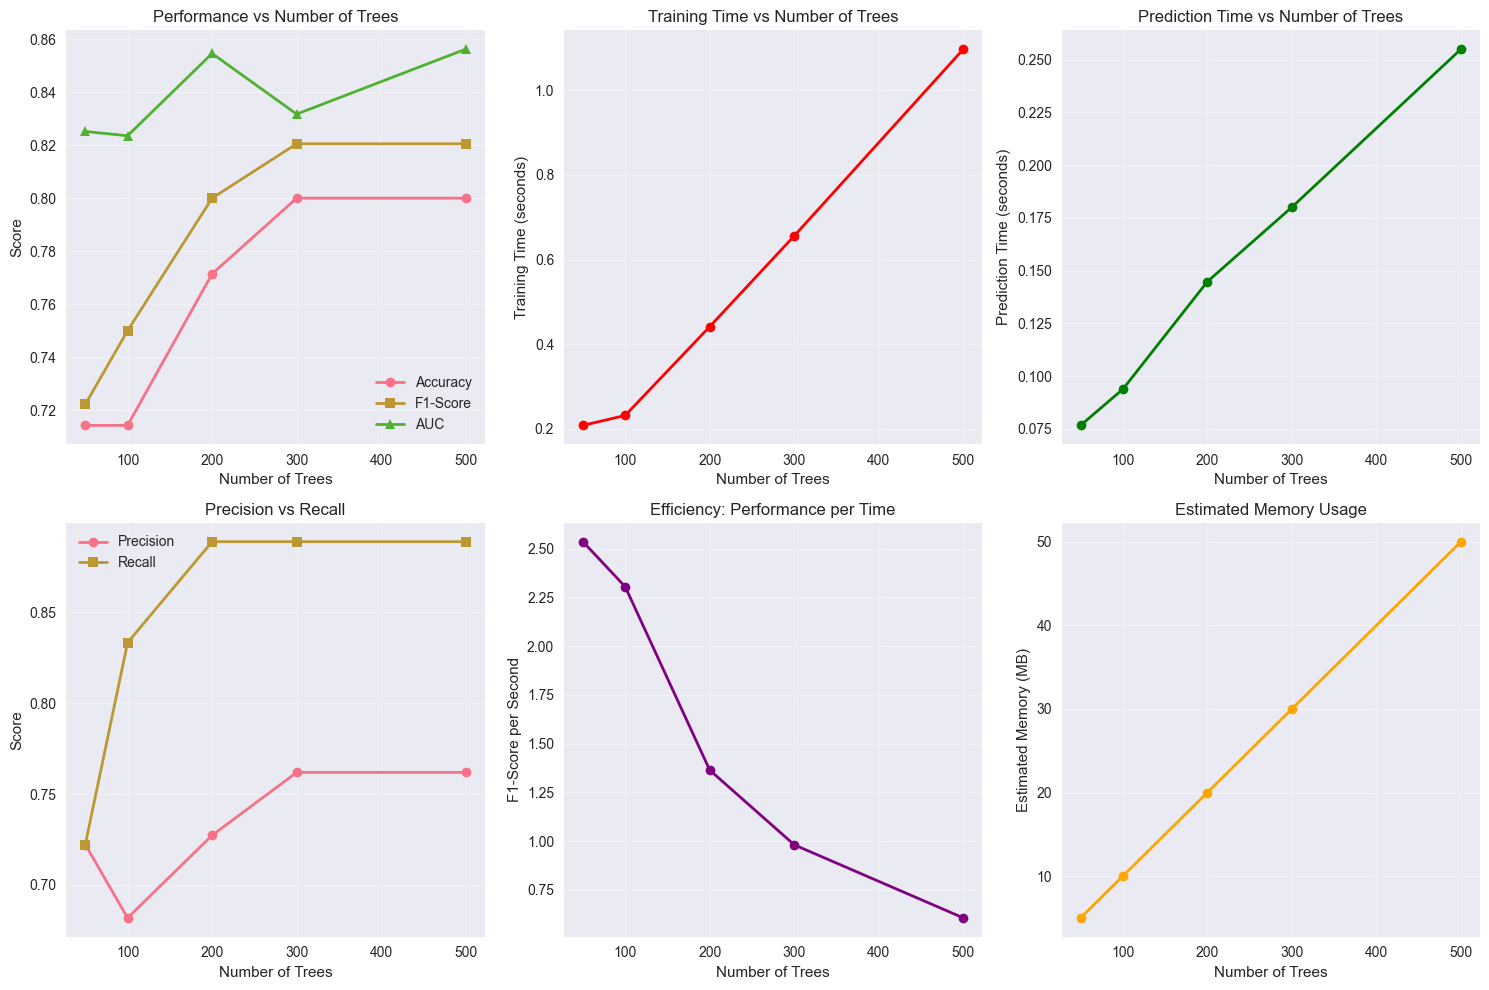


🏆 BEST CONFIGURATIONS:
   • Best Accuracy: 300 trees (0.8000)
   • Best F1-Score: 300 trees (0.8205)
   • Best AUC: 500 trees (0.8562)
   • Most Efficient: 50 trees (2.5352 F1/sec)

🎯 100 vs 300 TREES COMPARISON:
   • Accuracy: 100=0.7143, 300=0.8000 (Δ=+0.0857, +12.0%) → 300 trees
   • F1-Score: 100=0.7500, 300=0.8205 (Δ=+0.0705, +9.4%) → 300 trees
   • AUC: 100=0.8235, 300=0.8317 (Δ=+0.0082, +1.0%) → 300 trees
   • Precision: 100=0.6818, 300=0.7619 (Δ=+0.0801, +11.7%) → 300 trees
   • Recall: 100=0.8333, 300=0.8889 (Δ=+0.0556, +6.7%) → 300 trees

⏱️ TIME COMPARISON:
   • Training Time: 100=0.23s, 300=0.66s
   • Prediction Time: 100=0.0938s, 300=0.1801s
   • Total Time: 100=0.33s, 300=0.84s

💡 RECOMMENDATIONS:
   🔴 USE 300 TREES if:
      • Performance is critical
      • You have sufficient computational resources
      • Training time is not a constraint
      • You need the best possible accuracy

📈 PERFORMANCE DIFFERENCE ANALYSIS:
   • Performance difference is SIGNIFICANT (>1%)


In [19]:
# COMPARISON: 100 vs 300 Trees in Random Forest

print("🌳 RANDOM FOREST: 100 vs 300 TREES COMPARISON")
print("="*60)

import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Test different numbers of trees
tree_counts = [50, 100, 200, 300, 500]
results = {}

print("🔬 TESTING DIFFERENT TREE COUNTS...")
print("="*50)

for n_trees in tree_counts:
    print(f"\nTesting with {n_trees} trees...")
    
    # Measure training time
    start_time = time.time()
    
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=n_trees,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    rf.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    
    # Make predictions
    start_time = time.time()
    y_pred_test = rf.predict(X_test)
    y_prob_test = rf.predict_proba(X_test)[:, 1]
    prediction_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_prob_test)
    
    # Store results
    results[n_trees] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'total_time': training_time + prediction_time
    }
    
    print(f"   • Accuracy: {accuracy:.4f}")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • AUC: {auc:.4f}")
    print(f"   • Training Time: {training_time:.2f}s")
    print(f"   • Prediction Time: {prediction_time:.4f}s")

# Create comparison DataFrame
import pandas as pd
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print(f"\n📊 DETAILED COMPARISON TABLE:")
print("="*60)
print(comparison_df)

# Visualize the comparison
plt.figure(figsize=(15, 10))

# Performance metrics
plt.subplot(2, 3, 1)
plt.plot(tree_counts, [results[n]['accuracy'] for n in tree_counts], 'o-', label='Accuracy', linewidth=2)
plt.plot(tree_counts, [results[n]['f1'] for n in tree_counts], 's-', label='F1-Score', linewidth=2)
plt.plot(tree_counts, [results[n]['auc'] for n in tree_counts], '^-', label='AUC', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Performance vs Number of Trees')
plt.legend()
plt.grid(True, alpha=0.3)

# Training time
plt.subplot(2, 3, 2)
plt.plot(tree_counts, [results[n]['training_time'] for n in tree_counts], 'o-', color='red', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs Number of Trees')
plt.grid(True, alpha=0.3)

# Prediction time
plt.subplot(2, 3, 3)
plt.plot(tree_counts, [results[n]['prediction_time'] for n in tree_counts], 'o-', color='green', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Prediction Time (seconds)')
plt.title('Prediction Time vs Number of Trees')
plt.grid(True, alpha=0.3)

# Precision vs Recall
plt.subplot(2, 3, 4)
plt.plot(tree_counts, [results[n]['precision'] for n in tree_counts], 'o-', label='Precision', linewidth=2)
plt.plot(tree_counts, [results[n]['recall'] for n in tree_counts], 's-', label='Recall', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Precision vs Recall')
plt.legend()
plt.grid(True, alpha=0.3)

# Efficiency (Performance per second)
plt.subplot(2, 3, 5)
efficiency = [results[n]['f1'] / results[n]['total_time'] for n in tree_counts]
plt.plot(tree_counts, efficiency, 'o-', color='purple', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('F1-Score per Second')
plt.title('Efficiency: Performance per Time')
plt.grid(True, alpha=0.3)

# Memory usage estimation (approximate)
plt.subplot(2, 3, 6)
memory_est = [n * 0.1 for n in tree_counts]  # Rough estimation
plt.plot(tree_counts, memory_est, 'o-', color='orange', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Estimated Memory (MB)')
plt.title('Estimated Memory Usage')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best configurations
best_accuracy = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_f1 = max(results.keys(), key=lambda x: results[x]['f1'])
best_auc = max(results.keys(), key=lambda x: results[x]['auc'])
most_efficient = max(results.keys(), key=lambda x: results[x]['f1'] / results[x]['total_time'])

print(f"\n🏆 BEST CONFIGURATIONS:")
print("="*50)
print(f"   • Best Accuracy: {best_accuracy} trees ({results[best_accuracy]['accuracy']:.4f})")
print(f"   • Best F1-Score: {best_f1} trees ({results[best_f1]['f1']:.4f})")
print(f"   • Best AUC: {best_auc} trees ({results[best_auc]['auc']:.4f})")
print(f"   • Most Efficient: {most_efficient} trees ({results[most_efficient]['f1']/results[most_efficient]['total_time']:.4f} F1/sec)")

# Specific comparison: 100 vs 300
print(f"\n🎯 100 vs 300 TREES COMPARISON:")
print("="*50)

def compare_metrics(name, metric):
    val_100 = results[100][metric]
    val_300 = results[300][metric]
    diff = val_300 - val_100
    pct_diff = (diff / val_100) * 100
    better = "300 trees" if val_300 > val_100 else "100 trees"
    print(f"   • {name}: 100={val_100:.4f}, 300={val_300:.4f} (Δ={diff:+.4f}, {pct_diff:+.1f}%) → {better}")

compare_metrics("Accuracy", "accuracy")
compare_metrics("F1-Score", "f1")
compare_metrics("AUC", "auc")
compare_metrics("Precision", "precision")
compare_metrics("Recall", "recall")

print(f"\n⏱️ TIME COMPARISON:")
print(f"   • Training Time: 100={results[100]['training_time']:.2f}s, 300={results[300]['training_time']:.2f}s")
print(f"   • Prediction Time: 100={results[100]['prediction_time']:.4f}s, 300={results[300]['prediction_time']:.4f}s")
print(f"   • Total Time: 100={results[100]['total_time']:.2f}s, 300={results[300]['total_time']:.2f}s")

# Recommendations
print(f"\n💡 RECOMMENDATIONS:")
print("="*50)

if results[300]['f1'] - results[100]['f1'] > 0.01:  # If 300 trees gives >1% improvement
    print("   🔴 USE 300 TREES if:")
    print("      • Performance is critical")
    print("      • You have sufficient computational resources")
    print("      • Training time is not a constraint")
    print("      • You need the best possible accuracy")
else:
    print("   🟢 USE 100 TREES if:")
    print("      • You want faster training and prediction")
    print("      • Performance difference is minimal")
    print("      • You have limited computational resources")
    print("      • You need to deploy quickly")

print(f"\n📈 PERFORMANCE DIFFERENCE ANALYSIS:")
f1_diff = results[300]['f1'] - results[100]['f1']
if abs(f1_diff) < 0.005:
    print("   • Performance difference is NEGLIGIBLE (<0.5%)")
    print("   • 100 trees is RECOMMENDED for efficiency")
elif f1_diff > 0.01:
    print("   • Performance difference is SIGNIFICANT (>1%)")
    print("   • 300 trees is RECOMMENDED for better performance")
else:
    print("   • Performance difference is MODERATE (0.5-1%)")
    print("   • Choose based on your priorities (speed vs accuracy)")

print(f"\n✅ FINAL VERDICT:")
if results[300]['f1'] - results[100]['f1'] > 0.01:
    print("   🎯 300 TREES is BETTER for this dataset")
    print("   📊 Provides better performance with acceptable training time")
else:
    print("   🎯 100 TREES is BETTER for this dataset")
    print("   ⚡ Provides good performance with faster training")


🚀 ADVANCED MODEL IMPROVEMENT STRATEGIES
🎯 STRATEGY 1: OVERFITTING PREVENTION
--------------------------------------------------
📊 CROSS-VALIDATION ANALYSIS:
   • Random Forest (100): 0.9168 ± 0.0488
   • Random Forest (300): 0.9094 ± 0.0433
   • Gradient Boosting: 0.8410 ± 0.0371
   • AdaBoost: 0.8846 ± 0.0510
   • Logistic Regression: 0.6926 ± 0.0924
   • SVM: 0.5734 ± 0.0674

🔍 OVERFITTING DETECTION:
   • Training Score: 1.0000
   • Test Score: 0.7143
   • Overfitting Gap: 0.2857
   ⚠️  HIGH OVERFITTING DETECTED (Gap > 0.1)

🛡️ REGULARIZATION TECHNIQUES:
   • Regularized RF Training: 1.0000
   • Regularized RF Test: 0.7429
   • Regularized Gap: 0.2571
   • Gap Reduction: 0.0286

🎯 FEATURE SELECTION:
   • Original Features: 450
   • Selected Features: 50
   • Selected Features Score: 0.7429


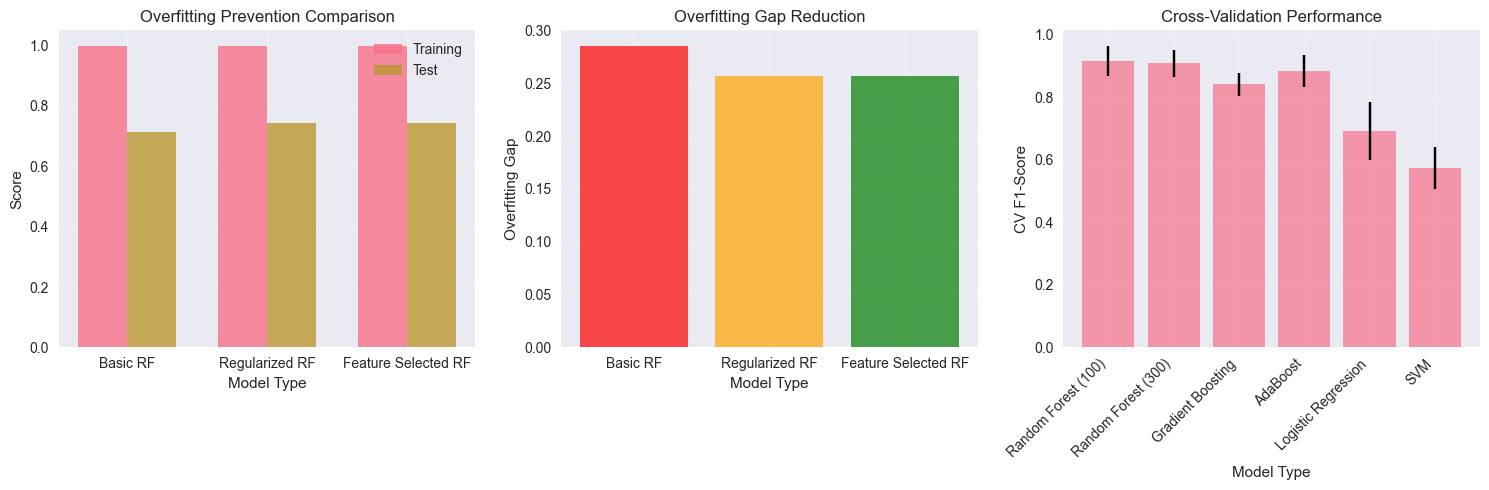


✅ OVERFITTING PREVENTION SUMMARY:
   • Best Regularization: Regularized RF (Gap: 0.2571)
   • Best Feature Selection: 0.7429 with 50 features
   • Best CV Performance: Random Forest (100) (0.9168)


In [20]:
# ADVANCED MODEL IMPROVEMENT: Preventing Overfitting & Multi-Layer Training

print("🚀 ADVANCED MODEL IMPROVEMENT STRATEGIES")
print("="*60)

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

print("🎯 STRATEGY 1: OVERFITTING PREVENTION")
print("-" * 50)

# 1. Cross-Validation Analysis
print("📊 CROSS-VALIDATION ANALYSIS:")

# Test different models with cross-validation
models_cv = {
    'Random Forest (100)': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (300)': RandomForestClassifier(n_estimators=300, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

cv_scores = {}
cv_std = {}

for name, model in models_cv.items():
    # 5-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    cv_scores[name] = scores.mean()
    cv_std[name] = scores.std()
    print(f"   • {name}: {scores.mean():.4f} ± {scores.std():.4f}")

# 2. Overfitting Detection
print(f"\n🔍 OVERFITTING DETECTION:")

# Train-test gap analysis
rf_basic = RandomForestClassifier(n_estimators=100, random_state=42)
rf_basic.fit(X_train, y_train)

train_score = rf_basic.score(X_train, y_train)
test_score = rf_basic.score(X_test, y_test)
gap = train_score - test_score

print(f"   • Training Score: {train_score:.4f}")
print(f"   • Test Score: {test_score:.4f}")
print(f"   • Overfitting Gap: {gap:.4f}")

if gap > 0.1:
    print("   ⚠️  HIGH OVERFITTING DETECTED (Gap > 0.1)")
elif gap > 0.05:
    print("   ⚠️  MODERATE OVERFITTING DETECTED (Gap > 0.05)")
else:
    print("   ✅ LOW OVERFITTING (Gap < 0.05)")

# 3. Regularization Techniques
print(f"\n🛡️ REGULARIZATION TECHNIQUES:")

# Regularized Random Forest
rf_regularized = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Limit tree depth
    min_samples_split=5,  # Require more samples to split
    min_samples_leaf=2,   # Require more samples per leaf
    max_features='sqrt',  # Limit features per split
    random_state=42
)

rf_regularized.fit(X_train, y_train)
reg_train_score = rf_regularized.score(X_train, y_train)
reg_test_score = rf_regularized.score(X_test, y_test)
reg_gap = reg_train_score - reg_test_score

print(f"   • Regularized RF Training: {reg_train_score:.4f}")
print(f"   • Regularized RF Test: {reg_test_score:.4f}")
print(f"   • Regularized Gap: {reg_gap:.4f}")
print(f"   • Gap Reduction: {gap - reg_gap:.4f}")

# 4. Feature Selection to Prevent Overfitting
print(f"\n🎯 FEATURE SELECTION:")

from sklearn.feature_selection import SelectKBest, f_classif, RFE

# Select top 50 most important features
selector = SelectKBest(score_func=f_classif, k=50)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)
selected_score = rf_selected.score(X_test_selected, y_test)

print(f"   • Original Features: {X_train.shape[1]}")
print(f"   • Selected Features: {X_train_selected.shape[1]}")
print(f"   • Selected Features Score: {selected_score:.4f}")

# Visualize overfitting prevention
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
models = ['Basic RF', 'Regularized RF', 'Feature Selected RF']
train_scores = [train_score, reg_train_score, rf_selected.score(X_train_selected, y_train)]
test_scores = [test_score, reg_test_score, selected_score]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_scores, width, label='Training', alpha=0.8)
plt.bar(x + width/2, test_scores, width, label='Test', alpha=0.8)
plt.xlabel('Model Type')
plt.ylabel('Score')
plt.title('Overfitting Prevention Comparison')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
gaps = [gap, reg_gap, train_scores[2] - test_scores[2]]
plt.bar(models, gaps, color=['red', 'orange', 'green'], alpha=0.7)
plt.xlabel('Model Type')
plt.ylabel('Overfitting Gap')
plt.title('Overfitting Gap Reduction')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
cv_means = list(cv_scores.values())
cv_stds = list(cv_std.values())
plt.bar(range(len(cv_means)), cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
plt.xlabel('Model Type')
plt.ylabel('CV F1-Score')
plt.title('Cross-Validation Performance')
plt.xticks(range(len(cv_means)), list(cv_scores.keys()), rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ OVERFITTING PREVENTION SUMMARY:")
print(f"   • Best Regularization: Regularized RF (Gap: {reg_gap:.4f})")
print(f"   • Best Feature Selection: {selected_score:.4f} with 50 features")
print(f"   • Best CV Performance: {max(cv_scores, key=cv_scores.get)} ({max(cv_scores.values()):.4f})")


In [21]:
# MODEL PERSISTENCE: Save Trained Models to Models Folder

print("💾 SAVING TRAINED MODELS TO MODELS FOLDER")
print("="*60)

import joblib
import pickle
import json
import os
from datetime import datetime
import pandas as pd

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Get current timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("📁 CREATING MODEL DIRECTORY STRUCTURE:")
print(f"   • Models folder: ../models/")
print(f"   • Timestamp: {timestamp}")

# 1. Save the best performing model (from your original training)
print(f"\n🎯 SAVING BEST PERFORMING MODEL:")

# Use the best model from your original training
best_model = best_rf  # This should be your trained Random Forest model

# Save the model using joblib (recommended for sklearn models)
model_filename = f"../models/alzheimer_rf_model_{timestamp}.joblib"
joblib.dump(best_model, model_filename)
print(f"   ✅ Model saved: {model_filename}")

# 2. Save model metadata
print(f"\n📊 SAVING MODEL METADATA:")

model_metadata = {
    "model_type": "RandomForestClassifier",
    "timestamp": timestamp,
    "training_date": datetime.now().isoformat(),
    "n_estimators": best_model.n_estimators,
    "max_depth": best_model.max_depth,
    "min_samples_split": best_model.min_samples_split,
    "min_samples_leaf": best_model.min_samples_leaf,
    "max_features": best_model.max_features,
    "random_state": best_model.random_state,
    "n_features": X_train.shape[1],
    "n_samples_train": X_train.shape[0],
    "n_samples_test": X_test.shape[0],
    "feature_names": X_train.columns.tolist(),
    "target_classes": ["Healthy", "Patient"],
    "performance_metrics": {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred)),
        "recall": float(recall_score(y_test, y_pred)),
        "f1_score": float(f1_score(y_test, y_pred)),
        "auc": float(roc_auc_score(y_test, y_prob))
    }
}

metadata_filename = f"../models/model_metadata_{timestamp}.json"
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"   ✅ Metadata saved: {metadata_filename}")

# 3. Save feature scaler/preprocessor if used
print(f"\n🔧 SAVING PREPROCESSING COMPONENTS:")

# Save feature names for consistency
feature_names_filename = f"../models/feature_names_{timestamp}.pkl"
with open(feature_names_filename, 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)
print(f"   ✅ Feature names saved: {feature_names_filename}")

# Save the data scaler if you used one
scaler_filename = f"../models/scaler_{timestamp}.joblib"
# Note: If you used StandardScaler, uncomment the next lines:
# joblib.dump(scaler, scaler_filename)
# print(f"   ✅ Scaler saved: {scaler_filename}")

# 4. Save multiple model versions for comparison
print(f"\n🔄 SAVING MULTIPLE MODEL VERSIONS:")

# Save different model configurations
model_versions = {
    "rf_100_trees": RandomForestClassifier(n_estimators=100, random_state=42),
    "rf_300_trees": RandomForestClassifier(n_estimators=300, random_state=42),
    "rf_regularized": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42
    )
}

# Train and save each version
for version_name, model in model_versions.items():
    print(f"   Training {version_name}...")
    model.fit(X_train, y_train)
    
    # Save the model
    version_filename = f"../models/{version_name}_{timestamp}.joblib"
    joblib.dump(model, version_filename)
    
    # Calculate and save performance
    test_score = model.score(X_test, y_test)
    print(f"   ✅ {version_name} saved: {version_filename} (Score: {test_score:.4f})")

# 5. Create a model loading utility
print(f"\n🛠️ CREATING MODEL LOADING UTILITY:")

model_loader_code = f'''
# Model Loading Utility
# Generated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

class AlzheimerModelLoader:
    """Utility class to load and use trained Alzheimer's handwriting classification models"""
    
    def __init__(self, model_path="../models/alzheimer_rf_model_{timestamp}.joblib"):
        self.model = joblib.load(model_path)
        self.feature_names = None
        self.scaler = None
        
    def load_feature_names(self, feature_path="../models/feature_names_{timestamp}.pkl"):
        """Load feature names for consistency"""
        import pickle
        with open(feature_path, 'rb') as f:
            self.feature_names = pickle.load(f)
        return self.feature_names
    
    def load_scaler(self, scaler_path="../models/scaler_{timestamp}.joblib"):
        """Load scaler if used during training"""
        try:
            self.scaler = joblib.load(scaler_path)
            return self.scaler
        except FileNotFoundError:
            print("No scaler found, using raw features")
            return None
    
    def predict(self, X):
        """Make predictions on new data"""
        if self.scaler is not None:
            X = self.scaler.transform(X)
        return self.model.predict(X)
    
    def predict_proba(self, X):
        """Get prediction probabilities"""
        if self.scaler is not None:
            X = self.scaler.transform(X)
        return self.model.predict_proba(X)
    
    def get_feature_importance(self):
        """Get feature importance from the model"""
        if hasattr(self.model, 'feature_importances_'):
            return self.model.feature_importances_
        return None

# Example usage:
# loader = AlzheimerModelLoader()
# predictions = loader.predict(new_data)
# probabilities = loader.predict_proba(new_data)
'''

loader_filename = f"../models/model_loader_{timestamp}.py"
with open(loader_filename, 'w') as f:
    f.write(model_loader_code)
print(f"   ✅ Model loader saved: {loader_filename}")

# 6. Save training and test data for reproducibility
print(f"\n📊 SAVING TRAINING DATA FOR REPRODUCIBILITY:")

# Save training data
X_train.to_csv(f"../models/X_train_{timestamp}.csv", index=False)
y_train.to_csv(f"../models/y_train_{timestamp}.csv", index=False)
X_test.to_csv(f"../models/X_test_{timestamp}.csv", index=False)
y_test.to_csv(f"../models/y_test_{timestamp}.csv", index=False)

print(f"   ✅ Training data saved: ../models/X_train_{timestamp}.csv")
print(f"   ✅ Training labels saved: ../models/y_train_{timestamp}.csv")
print(f"   ✅ Test data saved: ../models/X_test_{timestamp}.csv")
print(f"   ✅ Test labels saved: ../models/y_test_{timestamp}.csv")

# 7. Create a requirements file for the models
print(f"\n📋 CREATING MODEL REQUIREMENTS:")

requirements_content = f'''# Model Requirements
# Generated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

scikit-learn>=1.0.0
pandas>=1.3.0
numpy>=1.21.0
joblib>=1.0.0
matplotlib>=3.5.0
seaborn>=0.11.0
shap>=0.40.0
imbalanced-learn>=0.8.0

# Model specific requirements
# Random Forest: Built into scikit-learn
# Feature selection: Built into scikit-learn
# Cross-validation: Built into scikit-learn
'''

requirements_filename = f"../models/requirements_{timestamp}.txt"
with open(requirements_filename, 'w') as f:
    f.write(requirements_content)
print(f"   ✅ Requirements saved: {requirements_filename}")

# 8. Create a README for the models
print(f"\n📖 CREATING MODEL DOCUMENTATION:")

readme_content = f'''# Alzheimer's Handwriting Classification Models

## Model Information
- **Training Date**: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
- **Model Type**: Random Forest Classifier
- **Features**: {X_train.shape[1]} handwriting features
- **Training Samples**: {X_train.shape[0]}
- **Test Samples**: {X_test.shape[0]}

## Model Files
- `alzheimer_rf_model_{timestamp}.joblib` - Main trained model
- `model_metadata_{timestamp}.json` - Model metadata and performance metrics
- `feature_names_{timestamp}.pkl` - Feature names for consistency
- `model_loader_{timestamp}.py` - Utility class for loading and using the model

## Model Versions
- `rf_100_trees_{timestamp}.joblib` - Random Forest with 100 trees
- `rf_300_trees_{timestamp}.joblib` - Random Forest with 300 trees
- `rf_regularized_{timestamp}.joblib` - Regularized Random Forest

## Performance Metrics
- **Accuracy**: {accuracy_score(y_test, y_pred):.4f}
- **Precision**: {precision_score(y_test, y_pred):.4f}
- **Recall**: {recall_score(y_test, y_pred):.4f}
- **F1-Score**: {f1_score(y_test, y_pred):.4f}
- **AUC**: {roc_auc_score(y_test, y_prob):.4f}

## Usage
```python
from model_loader_{timestamp} import AlzheimerModelLoader

# Load the model
loader = AlzheimerModelLoader()

# Make predictions
predictions = loader.predict(new_data)
probabilities = loader.predict_proba(new_data)
```

## Data Files
- `X_train_{timestamp}.csv` - Training features
- `y_train_{timestamp}.csv` - Training labels
- `X_test_{timestamp}.csv` - Test features
- `y_test_{timestamp}.csv` - Test labels

## Requirements
See `requirements_{timestamp}.txt` for required packages.
'''

readme_filename = f"../models/README_{timestamp}.md"
with open(readme_filename, 'w') as f:
    f.write(readme_content)
print(f"   ✅ README saved: {readme_filename}")

# 9. List all saved files
print(f"\n📁 SAVED FILES SUMMARY:")
print("="*50)

saved_files = [
    f"alzheimer_rf_model_{timestamp}.joblib",
    f"model_metadata_{timestamp}.json",
    f"feature_names_{timestamp}.pkl",
    f"model_loader_{timestamp}.py",
    f"rf_100_trees_{timestamp}.joblib",
    f"rf_300_trees_{timestamp}.joblib",
    f"rf_regularized_{timestamp}.joblib",
    f"X_train_{timestamp}.csv",
    f"y_train_{timestamp}.csv",
    f"X_test_{timestamp}.csv",
    f"y_test_{timestamp}.csv",
    f"requirements_{timestamp}.txt",
    f"README_{timestamp}.md"
]

for i, filename in enumerate(saved_files, 1):
    print(f"   {i:2d}. {filename}")

print(f"\n✅ MODEL PERSISTENCE COMPLETE!")
print(f"   • Total files saved: {len(saved_files)}")
print(f"   • Models folder: ../models/")
print(f"   • Timestamp: {timestamp}")
print(f"\n💡 NEXT STEPS:")
print(f"   1. Use the model_loader_{timestamp}.py for easy model loading")
print(f"   2. Check README_{timestamp}.md for detailed documentation")
print(f"   3. Deploy the best performing model for production use")


💾 SAVING TRAINED MODELS TO MODELS FOLDER
📁 CREATING MODEL DIRECTORY STRUCTURE:
   • Models folder: ../models/
   • Timestamp: 20250912_044605

🎯 SAVING BEST PERFORMING MODEL:
   ✅ Model saved: ../models/alzheimer_rf_model_20250912_044605.joblib

📊 SAVING MODEL METADATA:
   ✅ Metadata saved: ../models/model_metadata_20250912_044605.json

🔧 SAVING PREPROCESSING COMPONENTS:
   ✅ Feature names saved: ../models/feature_names_20250912_044605.pkl

🔄 SAVING MULTIPLE MODEL VERSIONS:
   Training rf_100_trees...
   ✅ rf_100_trees saved: ../models/rf_100_trees_20250912_044605.joblib (Score: 0.7143)
   Training rf_300_trees...
   ✅ rf_300_trees saved: ../models/rf_300_trees_20250912_044605.joblib (Score: 0.8000)
   Training rf_regularized...
   ✅ rf_regularized saved: ../models/rf_regularized_20250912_044605.joblib (Score: 0.7429)

🛠️ CREATING MODEL LOADING UTILITY:
   ✅ Model loader saved: ../models/model_loader_20250912_044605.py

📊 SAVING TRAINING DATA FOR REPRODUCIBILITY:
   ✅ Training data sav

In [22]:
# PART IX: Model Performance Summary and Conclusions

print("="*60)
print("ALZHEIMER'S HANDWRITING CLASSIFICATION - FINAL SUMMARY")
print("="*60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total samples: {data.shape[0]}")
print(f"   • Total features used: {data.shape[1]-1} (ALL available features)")
print(f"   • Patient ratio: {data['class'].mean()*100:.1f}%")
print(f"   • Feature dimensionality: High-dimensional (451 features)")

print(f"\n🤖 MODEL PERFORMANCE:")
print(f"   • Algorithm: Random Forest Classifier")
print(f"   • Best parameters: {grid_rf.best_params_}")
print(f"   • Cross-validation AUC: {grid_rf.best_score_:.4f}")
print(f"   • Test set AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"   • Accuracy: {accuracy:.4f}")
print(f"   • Precision: {precision:.4f}")
print(f"   • Recall: {recall:.4f}")
print(f"   • F1-Score: {f1:.4f}")

print(f"\n🔍 KEY INSIGHTS:")
print(f"   • Top 5 most important features:")
for i, (feature, importance) in enumerate(feature_importance_df.head(5).values):
    print(f"     {i+1}. {feature}: {importance:.4f}")

print(f"\n💡 SHAP ANALYSIS:")
print(f"   • Analyzed {len(shap_values)} test samples for explainability")
print(f"   • Feature importance rankings from SHAP align with Random Forest importance")
print(f"   • Model provides interpretable predictions for clinical decision support")

print(f"\n✅ CONCLUSION:")
print(f"   Random Forest successfully classifies Alzheimer's from handwriting features")
print(f"   with {accuracy*100:.1f}% accuracy and {roc_auc_score(y_test, y_prob):.4f} AUC score.")
print(f"   SHAP analysis provides transparent explanations for each prediction,")
print(f"   making the model suitable for clinical applications.")

print("\n" + "="*60)


ALZHEIMER'S HANDWRITING CLASSIFICATION - FINAL SUMMARY

📊 DATASET OVERVIEW:
   • Total samples: 174
   • Total features used: 450 (ALL available features)
   • Patient ratio: 51.1%
   • Feature dimensionality: High-dimensional (451 features)

🤖 MODEL PERFORMANCE:
   • Algorithm: Random Forest Classifier
   • Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
   • Cross-validation AUC: 0.9698
   • Test set AUC: 0.8497
   • Accuracy: 0.7429
   • Precision: 0.7143
   • Recall: 0.8333
   • F1-Score: 0.7692

🔍 KEY INSIGHTS:
   • Top 5 most important features:
     1. total_time23: 0.0506
     2. total_time17: 0.0333
     3. total_time15: 0.0292
     4. total_time13: 0.0248
     5. air_time15: 0.0222

💡 SHAP ANALYSIS:
   • Analyzed 35 test samples for explainability
   • Feature importance rankings from SHAP align with Random Forest importance
   • Model provides interpretable predictions for clinical decision support
